# A Influência da Dimensão Espacial nos Valores Médios das Rendas Habitacionais: Uma Análise Econométrica Espacial das Freguesias da Região de Aveiro

### Quais os fatores espaciais que influenciam a variação dos valores médios das rendas dos alojamentos nas freguesias da região de Aveiro?

A variação dos valores das rendas nas freguesias da Região Aveiro não é aleatória, sendo influenciada por fatores espaciais como proximidade a centros urbanos, acessibilidade e dinâmica socioeconómica. A econometria permite analisar se há dependência espacial, ou seja, se os preços das rendas numa freguesia são influenciados pelos das freguesias vizinhas. Identificar esses padrões ajuda a compreender a formação dos preços, detetar clusters de rendas elevadas e fornecer informações relevantes para políticas habitacionais e planeamento urbano mais eficientes.

### Configuração do Ambiente e Importação de Bibliotecas

#### Importação de Bibliotecas

In [74]:
pip install pysal

  Using cached pysal-25.1-py3-none-any.whl.metadata (15 kB)
  Using cached libpysal-4.13.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached access-1.1.9-py3-none-any.whl.metadata (2.4 kB)
  Using cached esda-2.7.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached giddy-2.3.6-py3-none-any.whl.metadata (6.3 kB)
  Using cached inequality-1.1.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached pointpats-2.5.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached segregation-2.5.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached spaghetti-1.7.6-py3-none-any.whl.metadata (12 kB)
  Using cached mgwr-2.2.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached momepy-0.9.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached spglm-1.1.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached spint-1.0.7.tar.gz (28 kB)
  Preparing metadata (setup.py) ... done
  Using cached spreg-1.8.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tobler-0.12.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached splot-1.1.7-

In [71]:
import os
import sys
import importlib
from pathlib import Path

import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt
import contextily as cx

import folium

from pyogrio import list_layers

#### Definição da diretoria de trabalho na diretoria raiz do projeto

In [8]:
from pathlib import Path

# Find the project root (assuming marker-based or script-relative path)
def find_project_root(marker="README.md"):
    current_dir = Path.cwd()
    while current_dir != current_dir.parent:  # Traverse up until root
        if (current_dir / marker).exists():
            return current_dir
        current_dir = current_dir.parent
    raise FileNotFoundError(f"Marker '{marker}' not found in any parent directory.")

project_root = find_project_root()
sys.path.append(str(project_root))

# Or use a relative path: project_root = Path(__file__).resolve().parent.parent
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: /Users/filipasantos/Desktop/Mestrado CDACS/2º Semestre/ETE


In [5]:
module_path = os.path.abspath(os.path.join(r'.\src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
import utils.utils_ete2425

## Análise Espacial de Recursos Urbanos e Acessibilidade na Escala Local

### Preparação e Estruturação dos Dados Geoespaciais

Prepararam-se os dados geoespaciais que servirão como base para associar as freguesias aos valores da variável em estudo. Através do BGRI (Base Geográfica de Referenciação da Informação), obtêm-se unidades espaciais detalhadas da Região de Aveiro, delimitando a área de análise. Por outro lado, o CAOP (Carta Administrativa Oficial de Portugal) fornece os limites administrativos, sendo as freguesias a unidade territorial de interesse.

Para garantir a compatibilidade e facilitar a análise espacial, os dados converteram-se para o sistema de coordenadas global WGS84 (EPSG:4326). Esta transformação permite uma melhor integração dos dados em análises espaciais, mapas interativos e modelação econométrica espacial, assegurando que todas as camadas de informação estejam alinhadas no mesmo referencial.

#### Carregamento de Dados Geoespaciais

BGRI: https://mapas.ine.pt/download/index2021

REGIAO DE AVEIRO [BGRI21_16D.gpkg](https://mapas.ine.pt/download/filesGPG/2021/nuts3/BGRI21_16D.zip)

NUTS3: 191 região de aveiro.
link [CAOP2024](https://www.dgterritorio.gov.pt/sites/default/files/ficheiros-cartografia/Areas_Freg_Mun_Dist_Pais_CAOP2024.zip)


In [30]:
shape_REGIAO_AVEIRO = gpd.read_file(r'BGRI21_16D.gpkg', layer='BGRI21_16D')
#shape_REGIAO_AVEIRO = gpd.read_file(r'.\data\input' + r'\HW01\BGRI21_16D.gpkg', layer = 'BGRI21_16D' )
shape_REG_AVEIRO_WGS84 = shape_REGIAO_AVEIRO.to_crs(epsg=4326)

### Processamento e Análise dos Dados Espaciais e das Rendas Habitacionais

#### Carregamento e Estruturação dos Dados das Rendas Habitacionais

Optou-se pelo seguinte indicador disponibilizado pelo INE (Instituto Nacional de Estatística): **Valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) por Localização geográfica à data dos Censos [2021] (NUTS - 2013). Decenal – INE, Recenseamento da população e habitação – Censos 2021**. Nota-se que este indicador representa uma visão geral do mercado de arrendamento, agregando transações realizadas em diferentes momentos no tempo. Como está associado à operação censitária, apresenta uma cobertura abrangente, incluindo todas as freguesias do país e unidades espaciais de fins estatísticos, como as subsecções.

A seleção dos dados deste indicador incidiu exclusivamente sobre a Região de Aveiro, garantindo que a análise concentra-se apenas no território em estudo.

In [104]:
#db_excel_ine_rendaHab = pd.read_excel(r'.\data\input\HW01\HW01.xlsx',
#                                       skiprows=9,
#                                       skipfooter=5, header=None,
#                                       dtype='str'
#                                       )
db_excel_ine_rendaHab = pd.read_excel(r'HW01.xlsx',
                                       skiprows=9,
                                       skipfooter=5, header=None,
                                       dtype='str'
                                       )
db_excel_ine_rendaHab.rename(columns={0:"Designacao", 1:"GeoCod", 2:"ValMed_RendaMen"}, inplace=True)

In [105]:
#visualizando as duas primeiras observações (0,1) e as duas ultimas (-2,-1)
db_excel_ine_rendaHab.iloc[[0,1,-2,-1]]

,Designacao,GeoCod,ValMed_RendaMen
0,Região de Aveiro,16D,321.38
1,Águeda,0101,278.43
84,União das freguesias de Ponte de Vagos e Santa...,011813,294.26
85,União das freguesias de Vagos e Santo António,011814,315.68


In [106]:
db_excel_ine_rendaHab['LEVEL'] = db_excel_ine_rendaHab['GeoCod'].str.len()

db_excel_ine_rendaHab.head(4)

,Designacao,GeoCod,ValMed_RendaMen,LEVEL
0,Região de Aveiro,16D,321.38,3
1,Águeda,0101,278.43,4
2,Aguada de Cima,010103,256.49,6
3,Fermentelos,010109,277,6


In [107]:
#selecionando apenas as freguesias
db_excel_ine_rendaHab_freg = db_excel_ine_rendaHab[db_excel_ine_rendaHab['LEVEL'] == 6]
db_excel_ine_rendaHab_freg.iloc[0:3]

,Designacao,GeoCod,ValMed_RendaMen,LEVEL
2,Aguada de Cima,010103,256.49,6
3,Fermentelos,010109,277,6
4,Macinhata do Vouga,010112,262.7,6


#### Construção de Polígonos por freguesia para Análise Espacial

In [108]:
agg_columns = shape_REG_AVEIRO_WGS84.columns[13:45].tolist()

agg_dict = {col: 'sum' for col in agg_columns}

In [109]:
# Criar uma representação geométrica do municipio (polígono único)
# Permite-nos ter uma representação dos limites da área de estudo
# Atenção que mantém o mesmo referencial geográfico dos dados originais
shape_REG_Aveiro = shape_REG_AVEIRO_WGS84.dissolve(by='DTMNFR21', aggfunc=agg_dict)
#agrega a area para as freguesias

**Notas:**

Optámos por representar as freguesias através de **polígonos georreferenciados**, pois esta abordagem permite uma visualização clara da distribuição espacial das rendas da habitação. O uso de shapefiles (ficheiros extraídos do INE) facilita a sobreposição com dados estatísticos e a criação de matrizes de vizinhança.

Este tipo de representação, muito comum em análises econométricas espaciais,ajuda a perceber se freguesias próximas têm valores parecidos ou se há grandes diferenças entre vizinhos. Também nos permite calcular as distâncias entre freguesias e ver se os preços das rendas influenciam-se uns aos outros, fatores fundamentais para avaliar a dependência espacial e a autocorrelação dos dados.

#### Integração das Rendas Habitacionais com os Dados Espaciais

In [49]:
db_excel_ine_rendaHab_freg = db_excel_ine_rendaHab_freg.copy()
db_excel_ine_rendaHab_freg.rename(columns={"GeoCod":"DTMNFR21"}, inplace=True)
db_excel_ine_rendaHab_freg['ValMed_RendaMen'] = db_excel_ine_rendaHab_freg['ValMed_RendaMen'].astype(float)

In [50]:
shape_REG_Aveiro_rendaHab = shape_REG_Aveiro.merge(db_excel_ine_rendaHab_freg, left_on = 'DTMNFR21', right_on = 'DTMNFR21', how = 'left')

#### Visualização da Distribuição Espacial das Rendas

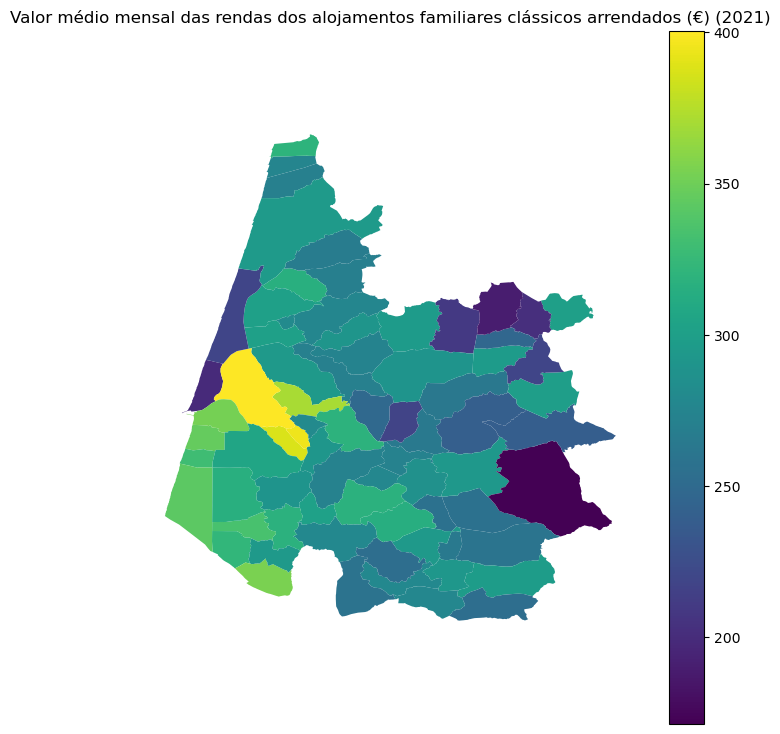

In [51]:
figura, ax = plt.subplots(1, figsize=(8, 9))
shape_REG_Aveiro_rendaHab.plot(ax=ax, column='ValMed_RendaMen',
                               legend=True)
ax.set_axis_off()
ax.set_title('Valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) (2021)')
plt.axis('equal')
plt.show()

**Análise:**

O mapa apresenta a distribuição espacial dos valores médios das rendas dos alojamentos familiares arrendados na região de Aveiro à data de 2021. A escala de cores *indica* uma variação significativa nos preços, com valores mais baixos representados por tons azulados e mais elevados por tons amarelados.

Observa-se que as freguesias com rendas mais elevadas estão concentradas na faixa ocidental da região, especialmente próximas ao litoral, onde há uma maior atratividade económica e turística. Em contraste, as freguesias do interior apresentam rendas mais reduzidas, sugerindo menor pressão da procura habitacional.

Uma exceção a este padrão verifica-se na área que inclui S. Jacinto e Torreira, onde as rendas médias são relativamente baixas, apesar da proximidade ao litoral. Esta discrepância pode estar associada a fatores como acessibilidade limitada, menor desenvolvimento urbano ou um mercado imobiliário menos dinâmico em comparação com outras zonas costeiras da região.

A distribuição espacial sugere a presença de dependência espacial, uma característica relevante para a análise econométrica. Freguesias adjacentes tendem a exibir valores semelhantes e próximos entre si, o que pode indicar a influência de fatores regionais como acessibilidade, oferta imobiliária e a dinâmica do mercado local.

#### Análise da Distribuição das Rendas e Classificação dos Dados

In [52]:
# https://pysal.org/mapclassify/api.html
# pysal.viz »» mapclassify
import mapclassify as mc

import seaborn as sns

In [53]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].describe().round(1)

count     74.0
mean     285.3
std       44.7
min      171.4
25%      263.0
50%      287.9
75%      304.6
max      400.4
Name: ValMed_RendaMen, dtype: float64


A visualização dos padrões geográficos das variáveis constitui um elemento chave na análise exploratória dos dados espacias.
No entanto, a visualização requer a configuração de paletes de cor para descrever as características marcantes dos dados. Importa assim perceber a distribuição dos dados e fornecer uma palete de cores que nos descreva as propriedades mais marcantes dessa distribuição.

Importa assim conjugar a exploração gráfica da distribuição dos dados - para a qual recorremos à livraria mapclassify e seaborn - bem como a sua visualização geográfica.

In [54]:
# Intervalos iguais

classi = mc.EqualInterval(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], k=7)
classi

EqualInterval

    Interval       Count
------------------------
[171.41, 204.12] |     4
(204.12, 236.84] |     4
(236.84, 269.55] |    15
(269.55, 302.27] |    32
(302.27, 334.98] |    11
(334.98, 367.70] |     4
(367.70, 400.41] |     4

##### Quantiles

In [55]:
classi_quant = mc.Quantiles(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], k=6)
classi_quant

Quantiles

    Interval       Count
------------------------
[171.41, 253.36] |    13
(253.36, 271.02] |    12
(271.02, 287.92] |    12
(287.92, 296.85] |    12
(296.85, 318.41] |    12
(318.41, 400.41] |    13

In [56]:
classi_quant.bins

array([253.35666667, 271.01666667, 287.92      , 296.85      ,
       318.41      , 400.41      ])

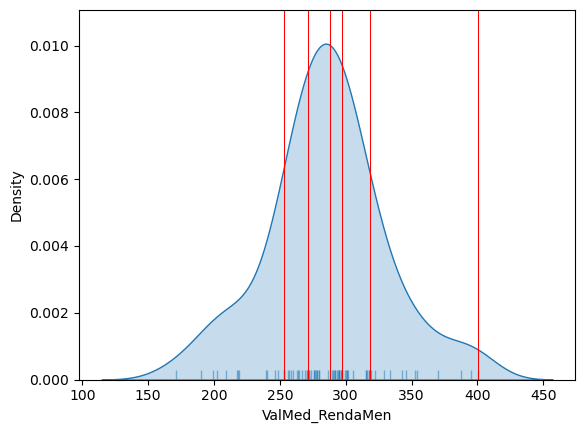

In [57]:
# Código padrão - usa a livraria seaborn (extende a matplotlib )
# https://seaborn.pydata.org/tutorial.html
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_quant.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

**Análise:**

O gráfico anterior é um gráfico de densidade KDE (Kernel Density Estimation) que representa a distribuição dos valores médios das rendas habitacionais nas freguesias da Região de Aveiro.

A forma do gráfico sugere que os valores das rendas seguem uma distribuição aproximadamente normal, com uma leve assimetria à direita. Maior parte dos valores das rendas está concentrada entre 230 € e 360 €, aproximadamente, com um pico próximo dos 280 €, que representa a moda da distribuição. É de notar, ainda, que existem algumas freguesias com rendas superiores a 400 €, podendo indicar a presença de valores atípicos (outliers) em zonas específicas.

As linhas vermelhas representam os intervalos definidos pelo método dos quantis, dividindo os dados em 6 classes de igual frequência. É possível observar que maior parte das freguesias está nos quantis centrais, reforçando a ideia de que os preços são relativamente homogéneos na região de Aveiro, embora haja alguma variação. A presença de quantis próximos entre si no centro da distribuição indica uma alta concentração de valores de rendas próximos, enquanto os quantis mais distantes nas extremidades sugerem que existem algumas freguesias com rendas significativamente mais baixas ou mais altas.

O gráfico confirma a existência de variabilidade espacial nos preços das rendas na região em estudo, justificando a necessidade de uma análise econométrica espacial de forma a entender melhor os fatores que influenciam essa variação.

#### Classificação das Rendas Habitacionais

Diferentes métodos estatísticos de classificação são aplicados aos valores das rendas. O **desvio padrão** separa os dados com base na média e no desvio padrão, o **boxplot** segmenta os dados conforme quartis, considerando a distribuição da variável, e o **Fisher Jenks** otimiza a separação de classes minimizando a variância dentro de cada grupo, auxiliando na segmentação espacial dos valores das rendas e na identificação de padrões estruturais.

In [64]:
# Desvio padrão médio
classi = mc.StdMean(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

StdMean

    Interval       Count
------------------------
[171.41, 195.96] |     2
(195.96, 240.64] |     8
(240.64, 329.99] |    55
(329.99, 374.67] |     6
(374.67, 400.41] |     3

In [65]:
# Baseado na caixa de bigodes
classi = mc.BoxPlot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

BoxPlot

    Interval       Count
------------------------
[171.41, 200.63] |     3
(200.63, 263.03] |    16
(263.03, 287.92] |    18
(287.92, 304.63] |    18
(304.63, 367.03] |    15
(367.03, 400.41] |     4

In [66]:
# Fisher Jenks

classi = mc.FisherJenks(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

FisherJenks

    Interval       Count
------------------------
[171.41, 218.64] |     8
(218.64, 278.46] |    26
(278.46, 305.63] |    22
(305.63, 354.46] |    14
(354.46, 400.41] |     4

#### Construção da Matriz de Pesos Espaciais

A matriz de pesos é essencial para modelar a dependência espacial. Definem-se vizinhanças com base no compartilhamento de fronteiras ou vértices, permitindo avaliar se as rendas numa freguesia estão correlacionadas com as das freguesias vizinhas.

In [67]:
import scipy

In [77]:
from pysal.lib import weights


# # https://pysal.org/libpysal/api.html
# from libpysal.weights.contiguity import Queen

# from libpysal.cg import voronoi_frames

In [78]:
# Contiguidade Queen
w_rook_shape_REG_Aveiro_rendaHab = weights.contiguity.Queen.from_dataframe(shape_REG_Aveiro_rendaHab)

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/1002145741.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook_shape_REG_Aveiro_rendaHab = weights.contiguity.Queen.from_dataframe(shape_REG_Aveiro_rendaHab)


In [79]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].describe()

count     74.000000
mean     285.316351
std       44.678263
min      171.410000
25%      263.032500
50%      287.920000
75%      304.632500
max      400.410000
Name: ValMed_RendaMen, dtype: float64

In [80]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].isna().sum()

np.int64(0)

**Nota:** Não há dados em falta, portanto não é necessário a imputação de dados.

### Associação (autocorrelação) espacial

A associação espacial emerge nos dados quando é possível observar correlações entre observações «próximas». Na análise univariada, pode-se calcular o "Índice de Moran - Índice Global de Associação Espacial" bem como a sua "variante" local: o "Índice Local de Associação Espacial" LISA (na sigla inglesa).

#### Associação espacial - Global

O **índice de Moran** mede a autocorrelação espacial, ou seja, verifica se há uma relação estatística entre os valores das rendas e os valores das freguesias vizinhas. Se os valores próximos forem muito semelhantes, existe autocorrelação espacial positiva, caso sejam muito diferentes, há autocorrelação espacial negativa.

Moran’s I é definido por:
$$
I = \frac{N}{W}\frac{\sum_{i} \sum_{j} w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i} (x_i - \bar{x})^2}
$$
onde:
- $( N )$ é o número total de observações no espaço
- $( W )$ é a soma de todos os pesos $( w_{ij} )$
- $( x_i )$ é o valor observado na localização $( i )$
- $( \bar{x} )$ é a média de todas as observações
- $( w_{ij} )$ é o peso espacial entre locais $( i )$ e $( j )$


**Interpretação de Moran's I:**
- $I > 0$ indica autocorrelação espacial positiva (valores similares próximos).
- $I < 0$ indica autocorrelação espacial negativa (valores dissimilares próximos).
- $I \approx 0$ indica ausência de autocorrelação espacial.



In [142]:
# Calcular o "spatial lag" (desfasamento espacial)

precoM2_lag = weights.lag_spatial(w_rook_shape_REG_Aveiro_rendaHab, shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
shape_REG_Aveiro_rendaHab["ValMed_RendaMen_lag"] = precoM2_lag

In [143]:
# "Normalizar" (cálculo de z-scores) as variáveis (original e desfasada)
shape_REG_Aveiro_rendaHab['ValMed_RendaMen_std'] = ( shape_REG_Aveiro_rendaHab['ValMed_RendaMen'] - shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].mean() )\
                    / shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].std()
shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag_std'] = ( shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'] - shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'].mean() )\
                    / shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'].std()

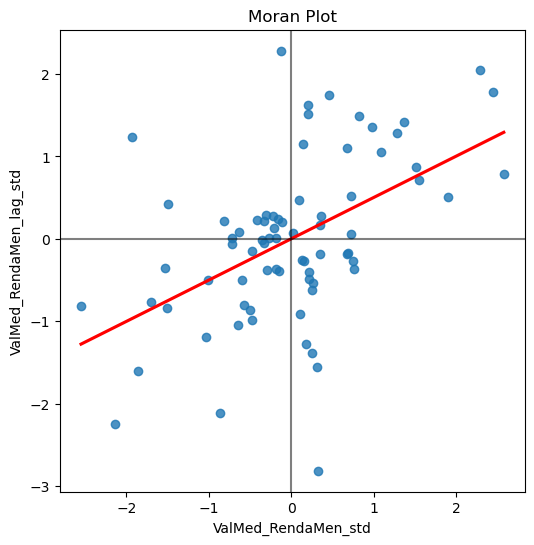

In [144]:
# Moran Plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='ValMed_RendaMen_std', y='ValMed_RendaMen_lag_std',
                ci=None, data=shape_REG_Aveiro_rendaHab, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

**Análise:**

O gráfico acima apresentado mostra a relação entre os valores normalizados da variável de interesse (renda habitacional média) e os valores médios vizinhos espaciais, sendo que a reta vermelha indica a tendência da relação espacial.

O coeficiente positivo da reta sugere uma autocorrelação espacial positiva fraca, significando que há uma leve tendência de locais com valores semelhantes de renda habitacional estarem próximos uns dos outros. No entanto, a dispersão dos pontos sugere que essa autocorrelação pode não ser muito forte.

In [145]:
# Gerar dados espaciais sintéticos
def gerar_dados_grelha(linhas=10, colunas=10, random_state=42):
    np.random.seed(random_state)
    x, y = np.meshgrid(range(colunas), range(linhas))
    pontos = np.column_stack([x.ravel(), y.ravel()])
    valores = np.random.rand(linhas * colunas)
    return pontos, valores

# Gerar dados sintéticos
pontos, valores = gerar_dados_grelha()


In [146]:


from libpysal.weights import lat2W

# Criar matriz de pesos
w = lat2W(int(np.sqrt(len(pontos))), int(np.sqrt(len(pontos))))
matriz_pesos = np.array(w.full()[0])

In [147]:
# Função para calcular Moran's I
def morans_I(valores, matriz_pesos):
    N = len(valores)
    W = matriz_pesos.sum()
    x_barra = np.mean(valores)
    desvios = valores - x_barra
    num = sum(matriz_pesos[i, j] * desvios[i] * desvios[j] for i in range(N) for j in range(N))
    denom = sum(desvios ** 2)
    return (N / W) * (num / denom)

In [148]:
moran_val = morans_I(valores, matriz_pesos)

In [149]:
moran_val

np.float64(0.04148554197807961)

In [150]:
np.array(w_rook_shape_REG_Aveiro_rendaHab.full()[0])



array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [151]:
moran_val_cs = morans_I(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab.full()[0] )

moran_val_cs

np.float64(0.33626064604798184)

#### Inferência

Os testes de permutação avaliam a significância estatística dos índices espaciais ao compará-los a distribuições empíricas geradas a partir de permutações aleatórias dos dados.

**Hipóteses dos Testes de Permutação - Moran I**
- **Hipótese nula ($H_0$)**: Não há autocorrelação espacial, os valores estão distribuídos aleatoriamente.
- **Hipótese alternativa ($H_1$)**: Existe autocorrelação espacial significativa.

#### Teste de Permutação para Significância Estatística

O teste de permutação avalia a significância da autocorrelação espacial. Ao gerar distribuições empíricas aleatórias, pode-se comparar o Moran's I observado com valores esperados sob a hipótese nula (ausência de padrão espacial). O *p-value* indica se a autocorrelação detetada é estatísticamente significante.

In [152]:
# Teste de permutação para Moran's I
def permutacao_morans_I(valores, matriz_pesos, num_permutacoes=999):
    I_obs = morans_I(valores, matriz_pesos)
    permutados = np.zeros(num_permutacoes)
    for i in range(num_permutacoes):
        valores_perm = np.random.permutation(valores)
        permutados[i] = morans_I(valores_perm, matriz_pesos)
    p_valor = np.mean(permutados >= I_obs)
    return I_obs, permutados, p_valor

In [153]:
#I_obs, I_permutados_obs, I_permutados_pvalue = permutacao_morans_I(valores, matriz_pesos, 999)
#I_obs, I_permutados_pvalue
I_obs, I_permutados_obs, I_permutados_pvalue = permutacao_morans_I(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'],
                                                                   w_rook_shape_REG_Aveiro_rendaHab.full()[0] , 999)
I_obs, I_permutados_pvalue


(np.float64(0.33626064604798184), np.float64(0.0))

**Análise:**

O valor do **Moran's I** observado (I_obs = 0.3170) é positivo, indicando a presença de autocorrelação espacial. Isso significa que locais com rendas habitacionais semelhantes tendem a estar próximos. Além disso, o valor de 0.3170 sugere uma autocorrelação moderada, pois está consideravelmente distante de zero.

Por outro lado, o ***p-value*** (I_permutados_pvalue = 0.0) é extremamente baixo, o que indica forte evidência estatística contra a hipótese nula de ausência de autocorrelação espacial significativa. Em outras palavras, a estrutura espacial observada nos dados não pode ser explicada por acaso, reforçando a existência de um padrão espacial significativo na distribuição das rendas habitacionais.

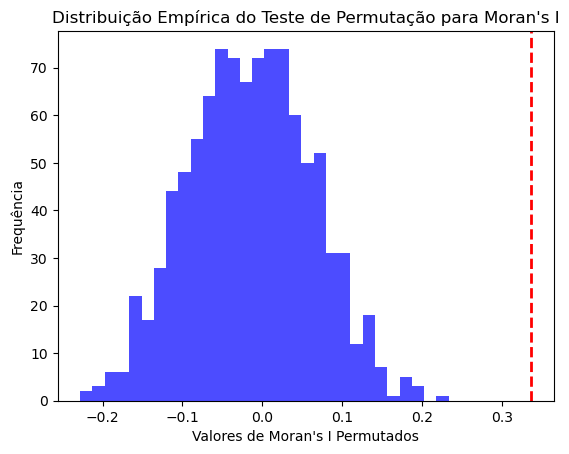

In [154]:
# Visualizar a distribuição empírica
plt.hist(I_permutados_obs, bins=30, alpha=0.7, color='blue')
plt.axvline(moran_val_cs, color='red', linestyle='dashed', linewidth=2)
plt.title("Distribuição Empírica do Teste de Permutação para Moran's I")
plt.xlabel("Valores de Moran's I Permutados")
plt.ylabel("Frequência")
plt.show()

**Análise:**

O histograma mostra a distribuição dos valores de Moran's I gerados por permutação aleatória, sendo que a linha vermelha representa o Moran's I observado nos dados reais.

Como dito anteriormente, como o valor de Moran's I observado está fora da distribuição, a autocorrelação espacial é estatisticamente significativa.

In [155]:
# Este código não está otimizado para grandes conjuntos de dados pelo que pode demorar algum tempo a executar

# I_permutados_cs_Iobs,I_permutados_cs, I_permutados_pvalue  = permutacao_morans_I(shape_BGRI21_Porto_CircEUlar['HousingPrice_Imputation'], w_rook_shape_BGRI21_Porto_CircEUlar.full()[0], 999)
# I_permutados_cs_Iobs,I_permutados_pvalue

In [156]:
# from pysal.explore import esda
from esda.moran import Moran
from esda.moran import Moran_Local

# https://splot.readthedocs.io/en/latest/api.html
# pysal.viz »» splot [splot.esda] (tem métodos para esda e outras componentes - ver api)
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_moran


In [157]:
moran_REG_Aveiro_rendaHab_WRook = Moran(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab)
moran_REG_Aveiro_rendaHab_WRook.I, moran_REG_Aveiro_rendaHab_WRook.p_sim

(np.float64(0.33626064604798184), np.float64(0.001))

#### Associação espacial - Local

LISA mede a autocorrelação local e é definido por:
$$
I_i = \frac{(x_i - \bar{x})}{S^2} \sum_j w_{ij} (x_j - \bar{x})
$$

onde:
- $I_i$ é o valor de Moran's I local para a observação $i$.
- $S^2$ é a variância da variável espacial.
- $w_{ij}$ é o peso espacial entre a observação $i$ e seus vizinhos $j$.


**Interpretação de Moran's I:**
- $I > 0$ indica autocorrelação espacial positiva (valores similares próximos).
- $I < 0$ indica autocorrelação espacial negativa (valores dissimilares próximos).
- $I \approx 0$ indica ausência de autocorrelação espacial.

Cada observação possui um valor LISA próprio, permitindo analisar padrões espaciais locais.


Interpretar os valores LISA:
   - **Alto-Alto (AA)**: valores elevados cercados por valores elevados.
   - **Baixo-Baixo (BB)**: valores baixos cercados por valores baixos.
   - **Alto-Baixo (AB)**: valores altos cercados por valores baixos.
   - **Baixo-Alto (BA)**: valores baixos cercados por valores altos.

In [158]:
# Função para calcular LISA
def lisa_local(valores, matriz_pesos):
    n = len(valores)
    media_valores = np.mean(valores)
    desvios = valores - media_valores
    W_soma = matriz_pesos.sum(axis=1)
    lisa_I = np.array([(n / W_soma[i]) * (desvios[i] * np.sum(matriz_pesos[i, :] * desvios)) for i in range(n)])
    return lisa_I

In [159]:
lisa_valores = lisa_local(valores, matriz_pesos)

#### Inferência

Os testes de permutação avaliam a significância estatística dos índices espaciais ao compará-los a distribuições empíricas geradas a partir de permutações aleatórias dos dados.

**Hipóteses dos Testes de Permutação - LISA**
- **Hipótese nula ($H_0$)**: O valor observado na localização $i$ não tem correlação espacial com seus vizinhos.
- **Hipótese alternativa ($H_1$)**: O valor na localização $i$ está correlacionado espacialmente com os vizinhos.

In [160]:
def permutacao_lisa(valores, matriz_pesos, num_permutacoes=999):
    lisa_obs = lisa_local(valores, matriz_pesos)
    N = len(valores)
    permutados = np.zeros((num_permutacoes, N))
    for p in range(num_permutacoes):
        valores_perm = np.random.permutation(valores)
        permutados[p] = lisa_local(valores_perm, matriz_pesos)
    p_valores = np.mean(np.abs(permutados) >= np.abs(lisa_obs), axis=0)
    return lisa_obs, p_valores

##### Usando a biblioteca PySAL

In [161]:
# calculate Moran_Local and plot
moranLocal_REG_Aveiro_rendaHab_WRook = Moran_Local(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab)

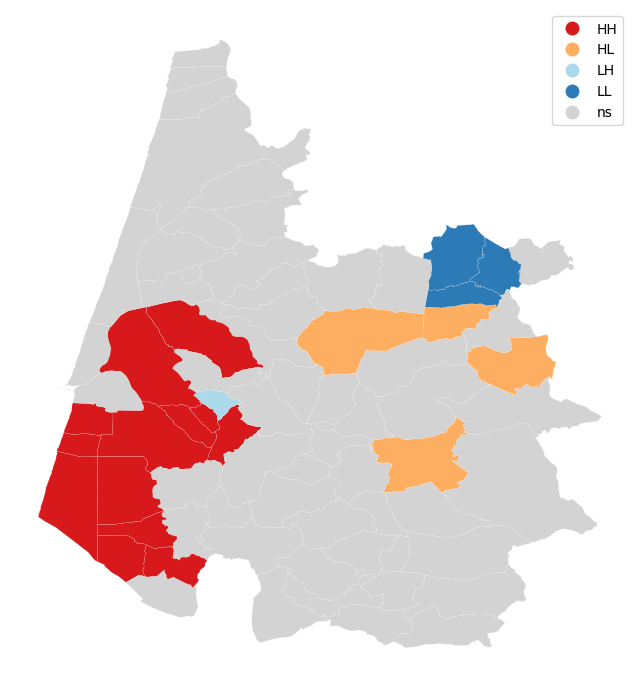

In [162]:
lisa_cluster(moranLocal_REG_Aveiro_rendaHab_WRook, shape_REG_Aveiro_rendaHab, p=0.05, figsize = (8,9))
plt.show()

O mapa apresenta a análise LISA das rendas habitacionais, que torna possível identificar clusters espaciais relevantes para a análise exploratória dos dados.

A distribuição espacial das rendas sugere que existe desigualdade territorial, com áreas valorizadas próximas entre si e zonas com rendas de valores mais baixos, a saber:

*   AA (HH, vermelho): Freguesias com rendas elevadas rodeadas por outras igualmente altas. Esta concentração está ao centro da região, associada a melhores infraestruturas, serviços e à proximidade ao litoral.
*   BB (LL, azul escuro): Áreas com rendas baixas cercadas por outras também baixas, localizadas no interior. Este padrão reflete menor procura imobiliária e menor dinamismo económico.
*   AB (HL, laranja): Refere-se a freguesias com rendas elevadas, rodeadas por áreas com rendas mais baixas. Exemplos incluem Águeda e Albergaria-a-Velha, que são influenciadas pela existência de zonas industriais, que consequentemente, tem impacto na valorização imobiliária dessas freguesias.
*   BA (LH, azul escuro): Existe apenas uma freguesia na região de Aveiro nesta categoria. Apresenta-se com rendas baixas, cercada por áreas de rendas altas, e normalmente representa zonas de transição ou de crescimento.
*   ns (Não significativo, cinzento): Regiões sem padrão estatisticamente significativo.

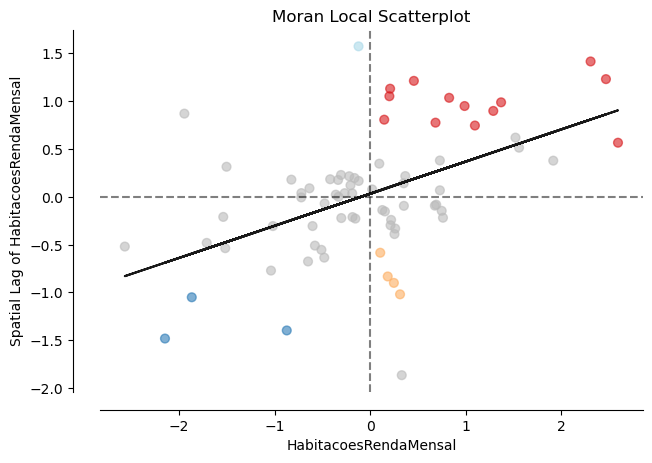

In [163]:
figura, ax = moran_scatterplot(moranLocal_REG_Aveiro_rendaHab_WRook, p=0.05)
ax.set_xlabel('HabitacoesRendaMensal')
ax.set_ylabel('Spatial Lag of HabitacoesRendaMensal')
plt.show()

Alinhado com a análise LISA, conseguimos também perceber através deste scatterplot as aglomerações de freguesias com valores semelhantes.

No **quadrante superior direito (AA)** estão representadas as unidades com valores mais altos e rodeadas por outras com valores parecidos. Enquanto que no **quadrante oposto (BB)**, temos um cluster de freguesias com valores baixos de renda vizinhos de outras com valores semelhantes.

Os outliers positivos presentes no **quadrante inferior direito (AB)** tem valores altos cercados por valores baixos, destacando-se da maioria das áreas ao redor.

O restante, que compõe a maioria da região, está distribuído de forma mais homogénea, sem uma clara tendência para valores altos ou baixos.

## Análise de preços de habitação à escala local

### Pré-processamento dos dados

#### Base de Dados do mercado de habitação de Aveiro

In [164]:
# Leitura dos dados
db_HousingMarket_AvrIlh_Ori = pd.read_csv(r'db_Housing_AvrIlh_F.csv', encoding = "ISO-8859-1") #encoding = "ISO-8859-1"
print(db_HousingMarket_AvrIlh_Ori.shape)
db_HousingMarket_AvrIlh_Ori[:3]

(674, 11)


,ID,Nature,Typology,Status,Price,A,Year,SOURCE_ID,Construc_Year,Longitude,Latitude
0,106045,1,4,4,80000.0,130.0,2018,2.0,1998,-8.653580,40.640789
1,106260,1,4,4,125000.0,109.0,2018,2.0,1989,-8.650984,40.639831
2,1963595,2,6,4,259000.0,250.0,2022,5.0,1951,-8.545166,40.619799


<Axes: >

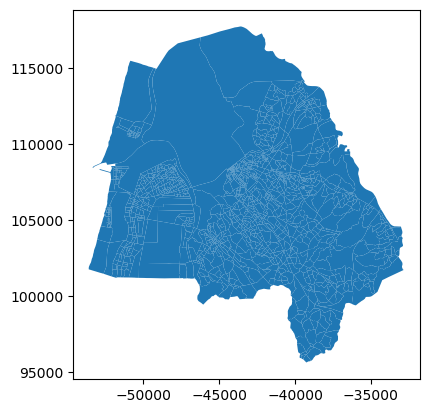

In [168]:
AVRILH_BGRI2021 = gpd.read_file(r'geopackage_ETE2425.gpkg', layer='BGRI2021_0105e0110')
AVRILH_BGRI2021.plot()

<Axes: >

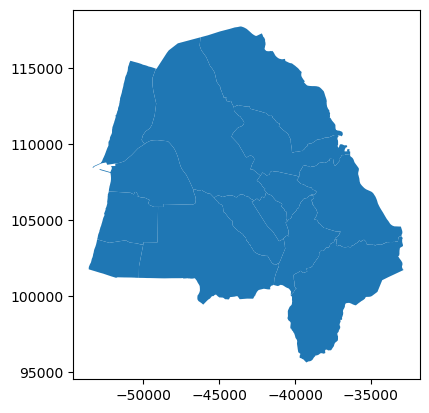

In [187]:
AVRILH_CAOP2018_FREG = gpd.read_file( r'geopackage_ETE2425.gpkg', layer = "AE_AVRILH_CAOP2018_FREG")
AVRILH_CAOP2018_FREG.plot()

<Axes: >

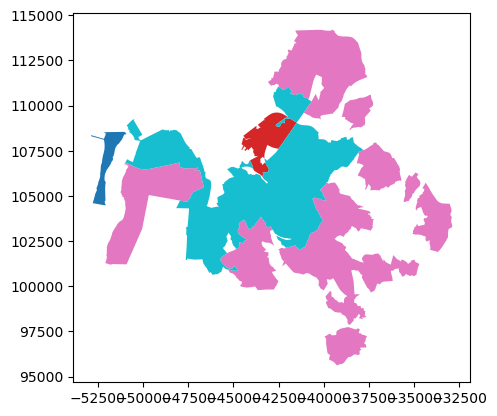

In [170]:
AE_AVRILH_MESO_4UTs = gpd.read_file(r'geopackage_ETE2425.gpkg', layer = "AE_AVRILH_MESO_4UTs_M2")
AE_AVRILH_MESO_4UTs.plot(column= 'MACROZONA4')

In [171]:
AE_AVRILH_MESO_4UTs.MACROZONA4.unique()

array(['Beaches', 'Center', 'Rural', 'Suburban'], dtype=object)

In [173]:
AE_AVRILH_MACRO_12UTs = gpd.read_file(r'geopackage_ETE2425.gpkg', layer = "AE_AVRILH_MACRO_12UTs")
AE_AVRILH_MACRO_12UTs.columns

Index(['spss_clust', 'MACROZONAS12', 'geometry'], dtype='object')

In [174]:
AE_AVRILH_MACRO_12UTs.MACROZONAS12.unique()

array(['MixedF01', 'MixedF02', 'MixedF03', 'MixedF04', 'MixedF05',
       'MixedF06', 'MixedF07', 'MixedF08', 'MixedF09', 'MixedF10',
       'MixedF11', 'MixedF12'], dtype=object)

<Axes: >

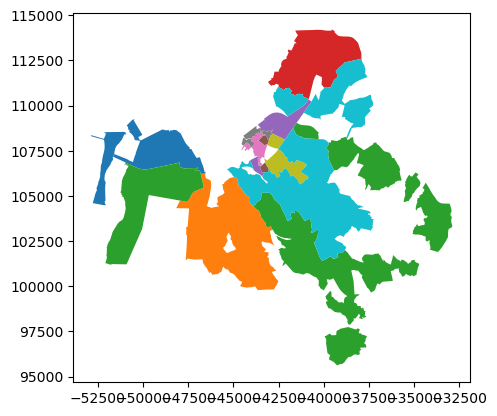

In [175]:
AE_AVRILH_MACRO_12UTs.plot(column='MACROZONAS12')

<Axes: >

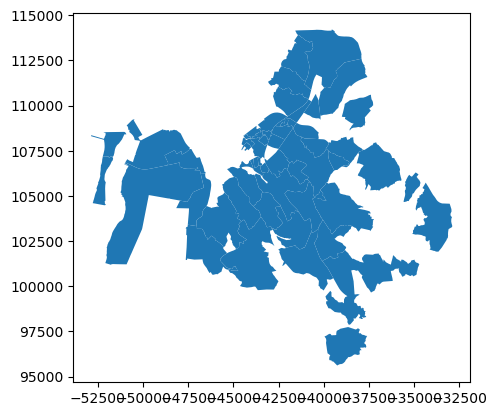

In [177]:
AE_AVRILH_MICRO_50UTs = gpd.read_file(r'geopackage_ETE2425.gpkg', layer = "AE_AVRILH_MICRO_50UTs")
AE_AVRILH_MICRO_50UTs.plot()

In [178]:
AE_AVRILH_MICRO_50UTs=AE_AVRILH_MICRO_50UTs.rename(columns = {'MACROZONA4':'MACROZONA4_'})

<Axes: >

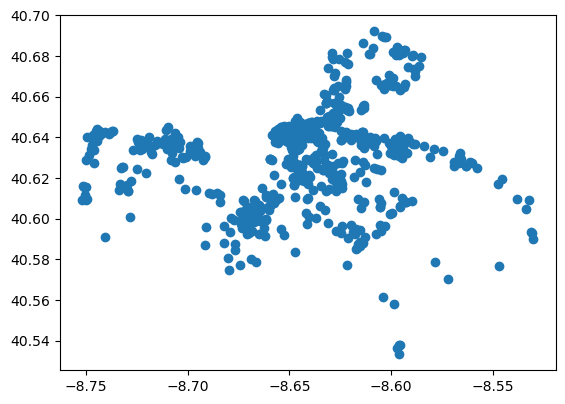

In [179]:
gdf_HousingMarket_AvrIlh = gpd.GeoDataFrame(db_HousingMarket_AvrIlh_Ori, geometry=gpd.points_from_xy(db_HousingMarket_AvrIlh_Ori.Longitude , db_HousingMarket_AvrIlh_Ori.Latitude))
gdf_HousingMarket_AvrIlh = gdf_HousingMarket_AvrIlh.drop(columns=['Longitude','Latitude'])
gdf_HousingMarket_AvrIlh.plot()

In [180]:
gdf_HousingMarket_AvrIlh = gdf_HousingMarket_AvrIlh.set_crs("EPSG:4326")
gdf_HousingMarket_AvrIlh.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [181]:
gdf_HousingMarket_AvrIlh = gdf_HousingMarket_AvrIlh.to_crs("EPSG:3763")

In [182]:
AE_AVRILH_limite = AE_AVRILH_MESO_4UTs.geometry.unary_union

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/2830820997.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  AE_AVRILH_limite = AE_AVRILH_MESO_4UTs.geometry.unary_union


<Axes: >

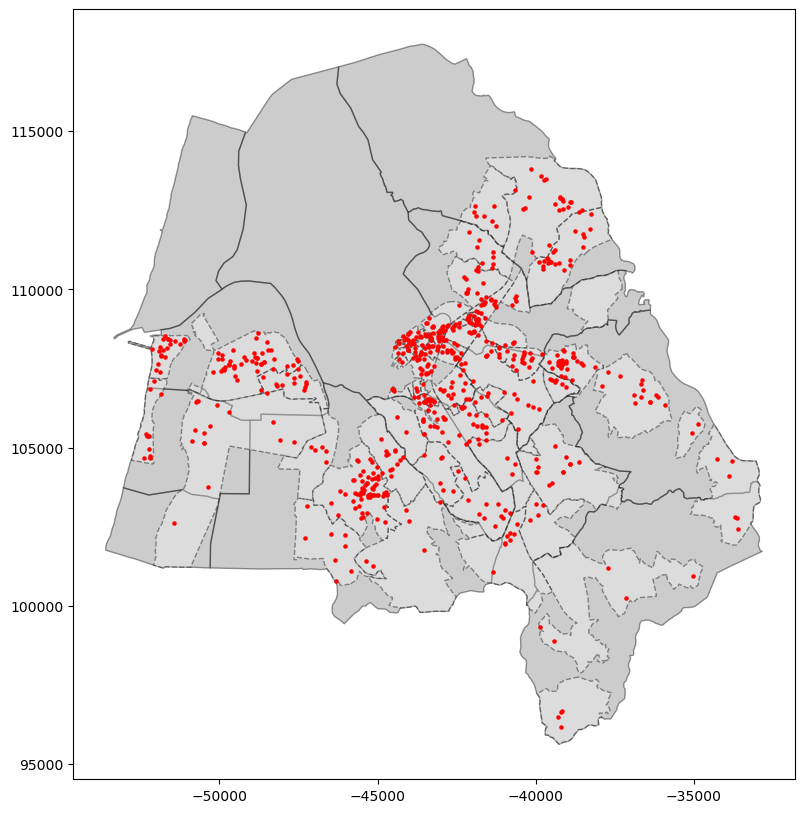

In [188]:
figura, ax = plt.subplots(figsize = (10,10) )
ax.set_aspect('equal')
gdf_HousingMarket_AvrIlh.plot(ax=ax,zorder=3, 
                      marker='.', 
                      color='red', 
                      markersize=20)
AE_AVRILH_MICRO_50UTs.plot(ax=ax, zorder=2, 
                             color='whitesmoke', 
                             edgecolor='black', linewidth=1, 
                             linestyle='--',
                            alpha = 0.4 )

AVRILH_CAOP2018_FREG.plot(ax=ax, zorder=1, 
                             color='grey', 
                             #facecolor="none",
                             edgecolor='black', linewidth=1,
                            alpha = 0.4 )
                        
# ax.set_ylim(95000, 120000)
# ax.set_xlim(-60000,-25000 )

#### Combinar informação espacial

In [189]:
print(list(AVRILH_CAOP2018_FREG.columns) )

['DICOFRE18', 'FREG18_la', 'AREAFREG18', 'MUNICOD', 'MUNI_Name', 'geometry']


In [190]:
print(gdf_HousingMarket_AvrIlh.shape)
gdf_HousingMarket_AvrIlh = gpd.sjoin(gdf_HousingMarket_AvrIlh, AVRILH_CAOP2018_FREG, how="left", predicate='within')
gdf_HousingMarket_AvrIlh.drop(columns='index_right', inplace=True)
print(gdf_HousingMarket_AvrIlh.shape)
gdf_HousingMarket_AvrIlh.head(3)

(674, 10)
(674, 15)


,ID,Nature,Typology,Status,Price,A,Year,SOURCE_ID,Construc_Year,geometry,DICOFRE18,FREG18_la,AREAFREG18,MUNICOD,MUNI_Name
0,106045,1,4,4,80000.0,130.0,2018,2.0,1998,POINT (-44026.912 108117.746),010517,União das freguesias de Glória e Vera Cruz,4.532068e+07,0105,AVEIRO
1,106260,1,4,4,125000.0,109.0,2018,2.0,1989,POINT (-43808 108010.1),010517,União das freguesias de Glória e Vera Cruz,4.532068e+07,0105,AVEIRO
2,1963595,2,6,4,259000.0,250.0,2022,5.0,1951,POINT (-34867.077 105738.234),010515,Eixo e Eirol,2.241555e+07,0105,AVEIRO


### Análise exploratória de dados e pré-processamento

In [192]:
# Leitura dos dados
db_HousingMarket_AvrIlh_Ori = pd.read_csv(r'db_Housing_AvrIlh_F.csv', encoding = "ISO-8859-1") #encoding = "ISO-8859-1"
print(db_HousingMarket_AvrIlh_Ori.shape)
db_HousingMarket_AvrIlh_Ori[:3]

(674, 11)


,ID,Nature,Typology,Status,Price,A,Year,SOURCE_ID,Construc_Year,Longitude,Latitude
0,106045,1,4,4,80000.0,130.0,2018,2.0,1998,-8.653580,40.640789
1,106260,1,4,4,125000.0,109.0,2018,2.0,1989,-8.650984,40.639831
2,1963595,2,6,4,259000.0,250.0,2022,5.0,1951,-8.545166,40.619799


#### Variáveis continuais

##### Variável dependente

In [193]:
gdf_HousingMarket_AvrIlh['LnPrice'] = np.log(gdf_HousingMarket_AvrIlh["Price"])

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/877443303.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


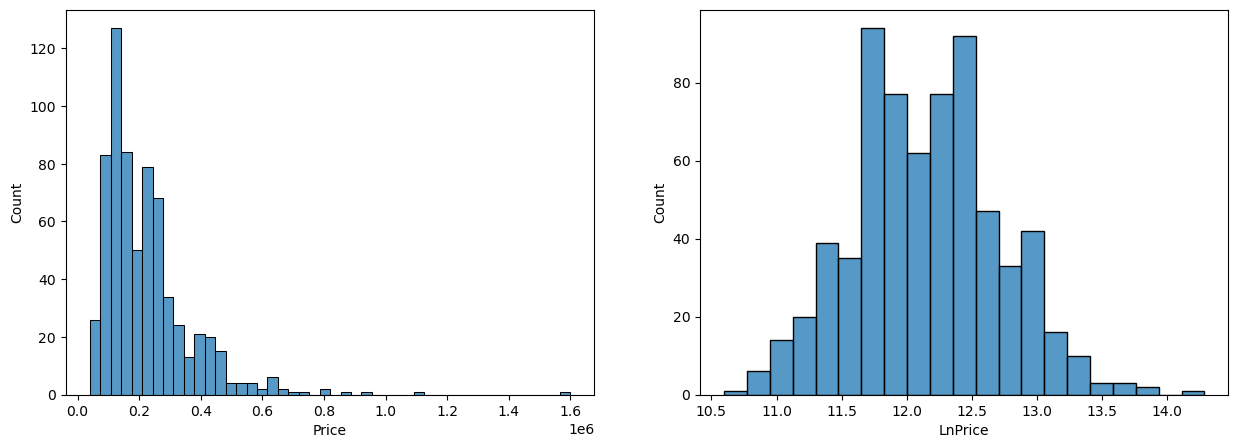

In [194]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="Price", ax=ax[0])
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="LnPrice", ax=ax[1])
fig.show()

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/1244531959.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


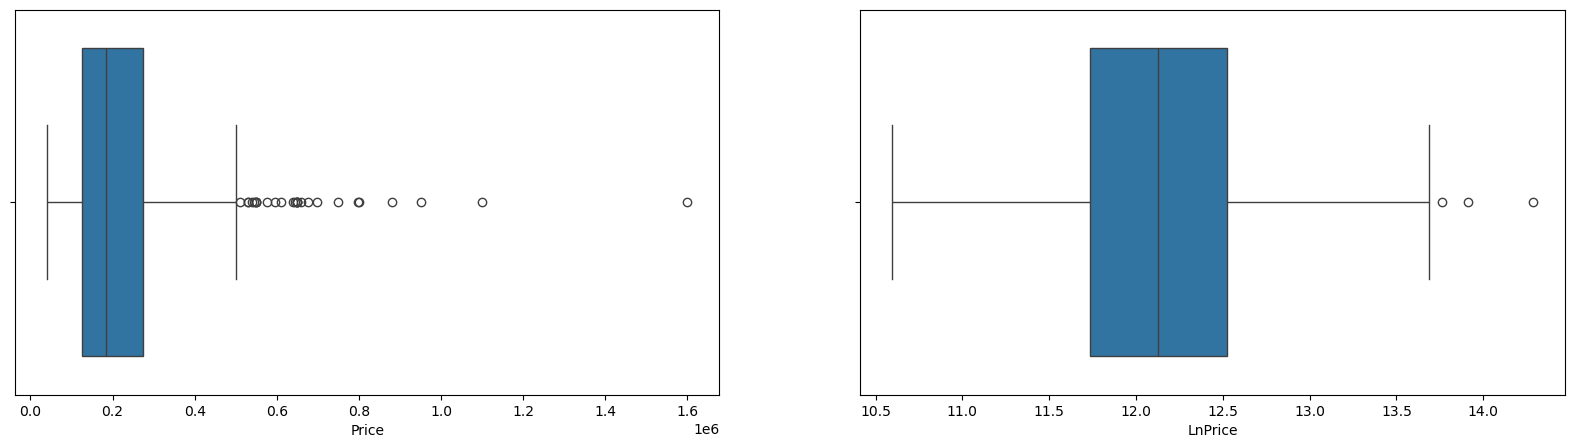

In [195]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.boxplot(x=gdf_HousingMarket_AvrIlh["Price"], ax=ax[0])
sns.boxplot(x=gdf_HousingMarket_AvrIlh["LnPrice"], ax=ax[1])
fig.show()

In [196]:
# Quantiles

classi_quant = mc.StdMean(gdf_HousingMarket_AvrIlh['Price'] )
classi_quant

StdMean

        Interval           Count
--------------------------------
(      -inf,  -70981.03] |     0
( -70981.03,   75930.16] |    33
(  75930.16,  369752.53] |   551
( 369752.53,  516663.72] |    64
( 516663.72, 1600000.00] |    26

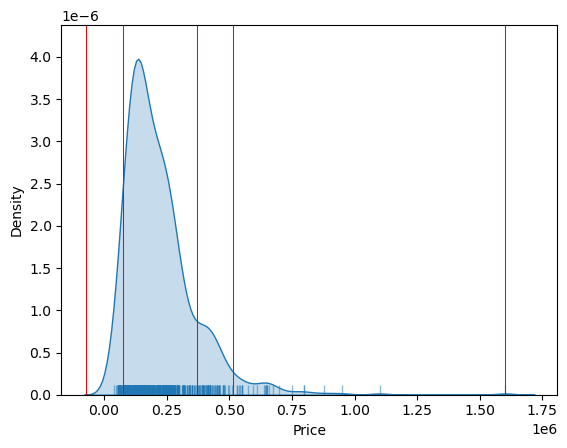

In [197]:
# Código padrão - usa a livraria seaborn (extende a matplotlib )
# https://seaborn.pydata.org/tutorial.html
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(gdf_HousingMarket_AvrIlh['Price'], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(gdf_HousingMarket_AvrIlh['Price'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_quant.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

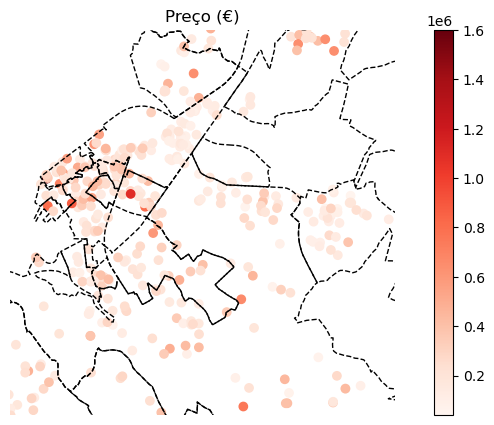

In [198]:
# color maps references: https://matplotlib.org/stable/gallery/color/colormap_reference.html
figura, ax = plt.subplots(1, figsize=(10, 5))
gdf_HousingMarket_AvrIlh.plot(ax=ax,
                              zorder=1,  
                              column='Price',
                              cmap='Reds', 
                              legend=True) 

AE_AVRILH_MACRO_12UTs.plot(ax=ax, 
                           zorder=2,
                           edgecolor='black', 
                           linewidth=1, 
                           linestyle='--',
                           facecolor="none",
                           #alpha = 0.4 
                           #color='whitesmoke',
                           )
ax.set_axis_off()
ax.set_xbound(-45000, -38000 )
ax.set_ybound(111000, 104000)
ax.set_title('Preço (€)')
# plt.axis('equal')
plt.show()

##### Variável independente

In [199]:
gdf_HousingMarket_AvrIlh['LnA'] = np.log(gdf_HousingMarket_AvrIlh["A"])

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/1915460742.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


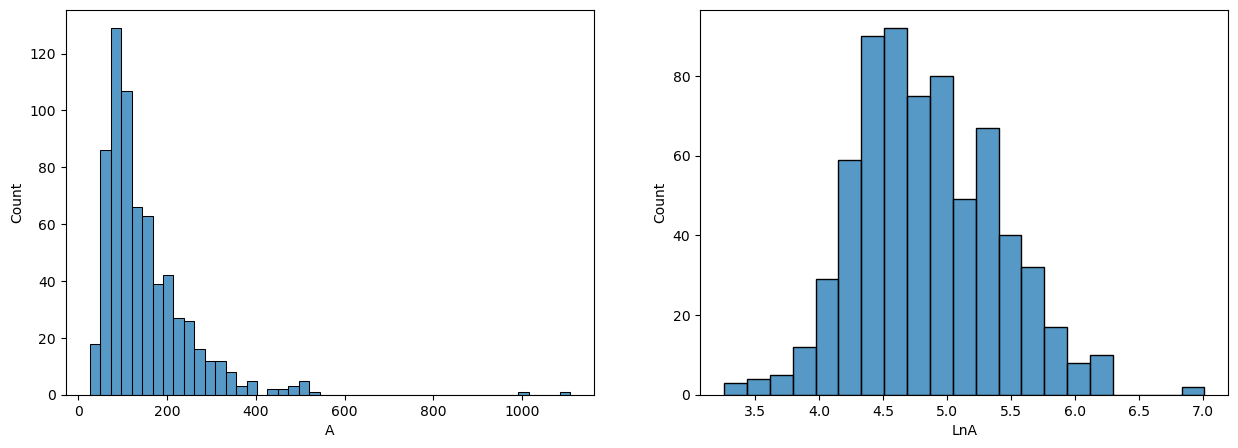

In [200]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="A", ax=ax[0])
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="LnA", ax=ax[1])
fig.show()

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/277307012.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


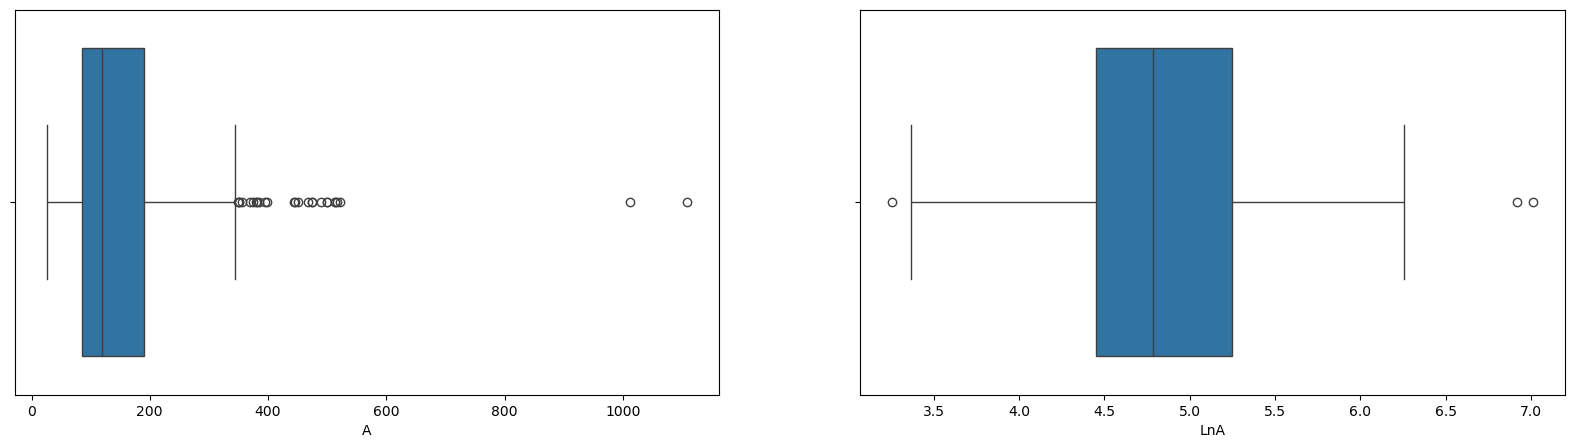

In [201]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.boxplot(x=gdf_HousingMarket_AvrIlh["A"], ax=ax[0])
sns.boxplot(x=gdf_HousingMarket_AvrIlh["LnA"], ax=ax[1])
fig.show()

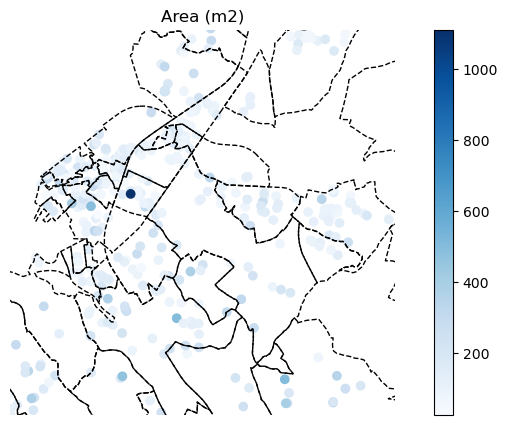

In [202]:
# color maps references: https://matplotlib.org/stable/gallery/color/colormap_reference.html
figura, ax = plt.subplots(1, figsize=(10, 5))
gdf_HousingMarket_AvrIlh.plot(ax=ax,
                              zorder=1,  
                              column='A',
                              cmap='Blues', 
                              legend=True) 

AE_AVRILH_MICRO_50UTs.plot(ax=ax, 
                           zorder=2,
                           edgecolor='black', 
                           linewidth=1, 
                           linestyle='--',
                           facecolor="none",
                           #alpha = 0.4 
                           #color='whitesmoke',
                        )
ax.set_axis_off()
ax.set_xbound(-45000, -38000 )
ax.set_ybound(111000, 104000)
ax.set_title('Area (m2)')
# plt.axis('equal')
plt.show()

##### Preço & Área

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/2193284439.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


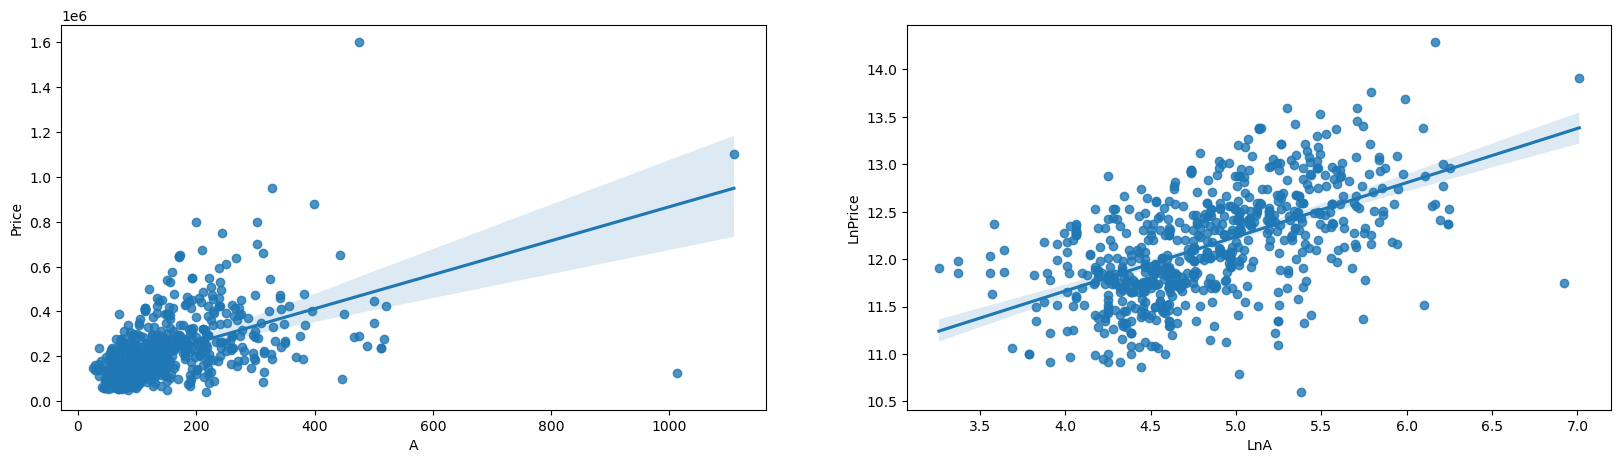

In [203]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.regplot(data=gdf_HousingMarket_AvrIlh, x="A", y="Price", ax=ax[0])
sns.regplot(data=gdf_HousingMarket_AvrIlh, x="LnA", y="LnPrice", ax=ax[1])
fig.show()

##### Variável dependente Preço/m2

In [204]:
gdf_HousingMarket_AvrIlh['PriceM2'] = gdf_HousingMarket_AvrIlh["Price"]/gdf_HousingMarket_AvrIlh["A"]
gdf_HousingMarket_AvrIlh['LnPriceM2'] = np.log(gdf_HousingMarket_AvrIlh['PriceM2'] )

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/4208540412.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


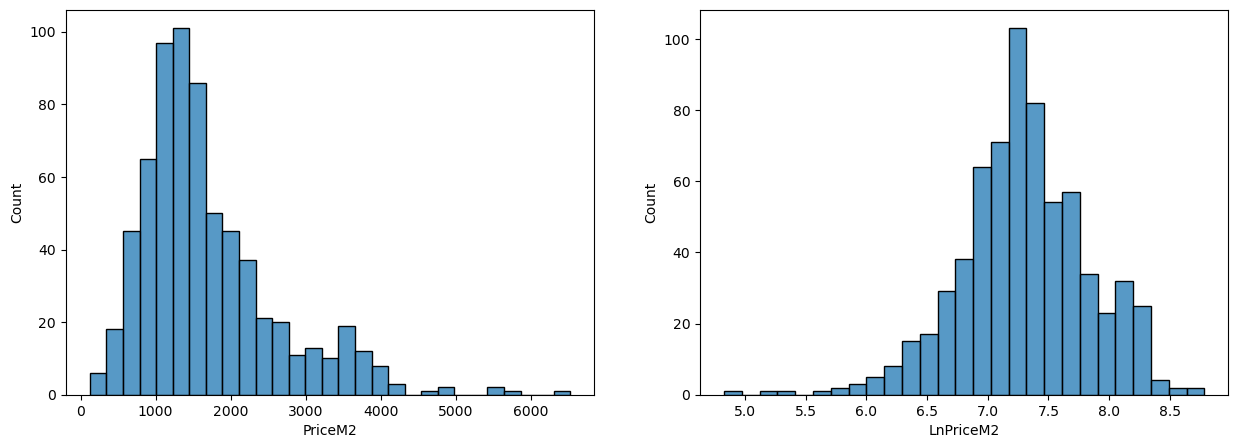

In [205]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="PriceM2", ax=ax[0])
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="LnPriceM2", ax=ax[1])
fig.show()

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/2290764819.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


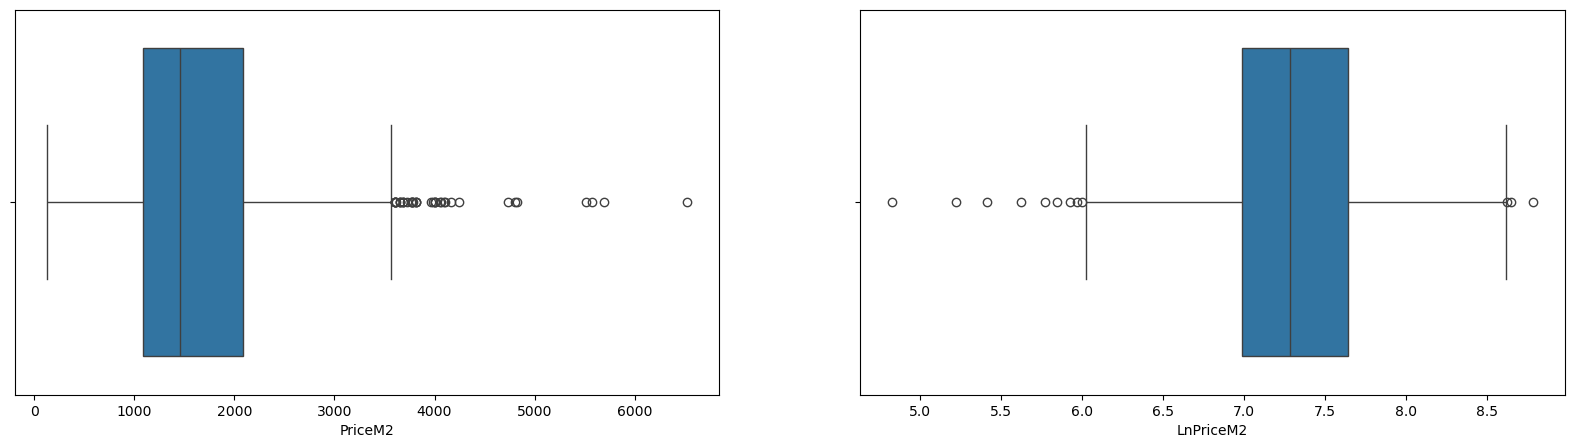

In [206]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.boxplot(x=gdf_HousingMarket_AvrIlh["PriceM2"], ax=ax[0])
sns.boxplot(x=gdf_HousingMarket_AvrIlh["LnPriceM2"], ax=ax[1])
fig.show()

In [207]:
# Quantiles

classi_quant = mc.StdMean(gdf_HousingMarket_AvrIlh['PriceM2'] )
classi_quant

StdMean

     Interval        Count
--------------------------
(   -inf, -133.33] |     0
(-133.33,  781.11] |    67
( 781.11, 2610.00] |   512
(2610.00, 3524.44] |    51
(3524.44, 6527.78] |    44

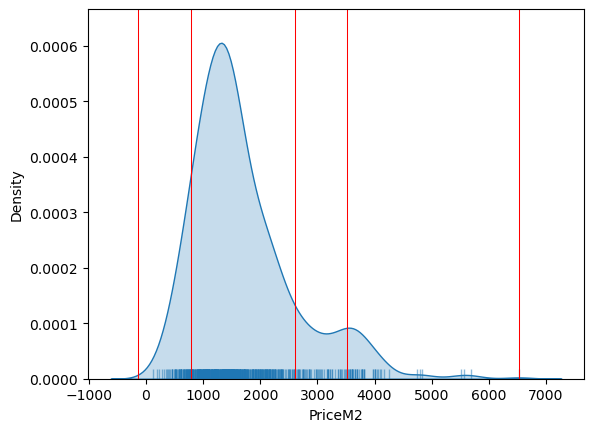

In [208]:
# Código padrão - usa a livraria seaborn (extende a matplotlib )
# https://seaborn.pydata.org/tutorial.html
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(gdf_HousingMarket_AvrIlh['PriceM2'], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(gdf_HousingMarket_AvrIlh['PriceM2'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_quant.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

##### Variável NQuartos


In [209]:
gdf_HousingMarket_AvrIlh['Typology'].unique()

array([4, 6, 5, 3, 1, 2, 7])

In [210]:
gdf_HousingMarket_AvrIlh['LnTypology'] = np.log(gdf_HousingMarket_AvrIlh["Typology"])

<Axes: xlabel='Typology', ylabel='Count'>

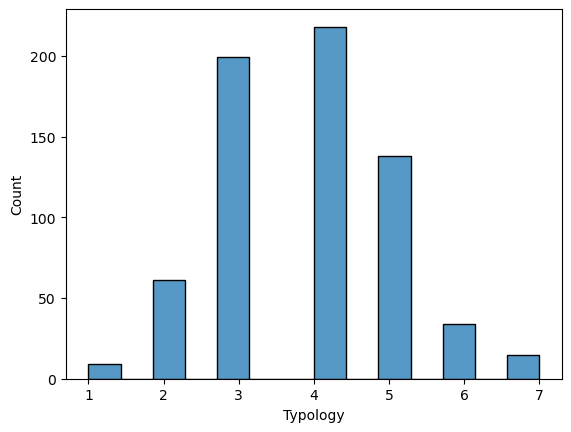

In [211]:
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="Typology")

<Axes: xlabel='Typology', ylabel='LnPriceM2'>

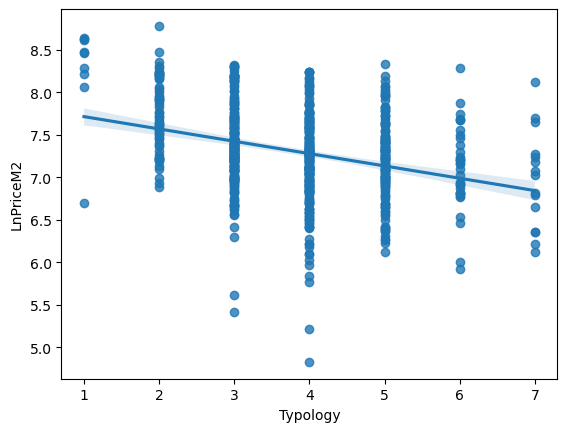

In [212]:
sns.regplot(data=gdf_HousingMarket_AvrIlh, x="Typology", y="LnPriceM2")


<Axes: xlabel='Typology', ylabel='LnA'>

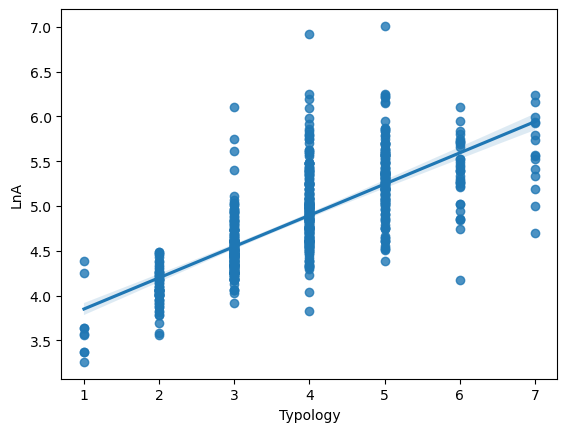

In [213]:
sns.regplot(data=gdf_HousingMarket_AvrIlh, x="Typology", y="LnA")

##### Variável do imóvel

In [214]:
gdf_HousingMarket_AvrIlh['Construc_Year'].isna().sum()

np.int64(0)

In [215]:
gdf_HousingMarket_AvrIlh.groupby('Construc_Year')['ID'].count()

Construc_Year
1900     8
1918     1
1928     1
1934     1
1950     4
        ..
2019     8
2020    12
2021    17
2022    42
2023    21
Name: ID, Length: 64, dtype: int64

In [216]:
gdf_HousingMarket_AvrIlh['Idade'] = (2024 - gdf_HousingMarket_AvrIlh['Construc_Year'])

In [217]:
gdf_HousingMarket_AvrIlh['Idade'] 

0      26
1      35
2      73
3      73
4      10
       ..
669    21
670    56
671    17
672    34
673    21
Name: Idade, Length: 674, dtype: int64

In [218]:
np.log(gdf_HousingMarket_AvrIlh["Idade"])

0      3.258097
1      3.555348
2      4.290459
3      4.290459
4      2.302585
         ...   
669    3.044522
670    4.025352
671    2.833213
672    3.526361
673    3.044522
Name: Idade, Length: 674, dtype: float64

In [219]:
gdf_HousingMarket_AvrIlh['LnIdade'] = np.log(gdf_HousingMarket_AvrIlh["Idade"])

In [220]:
gdf_HousingMarket_AvrIlh['Idade'].isna().sum()

np.int64(0)

In [221]:
np.isinf(gdf_HousingMarket_AvrIlh['LnIdade']).values.any()

np.False_

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/2169128395.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


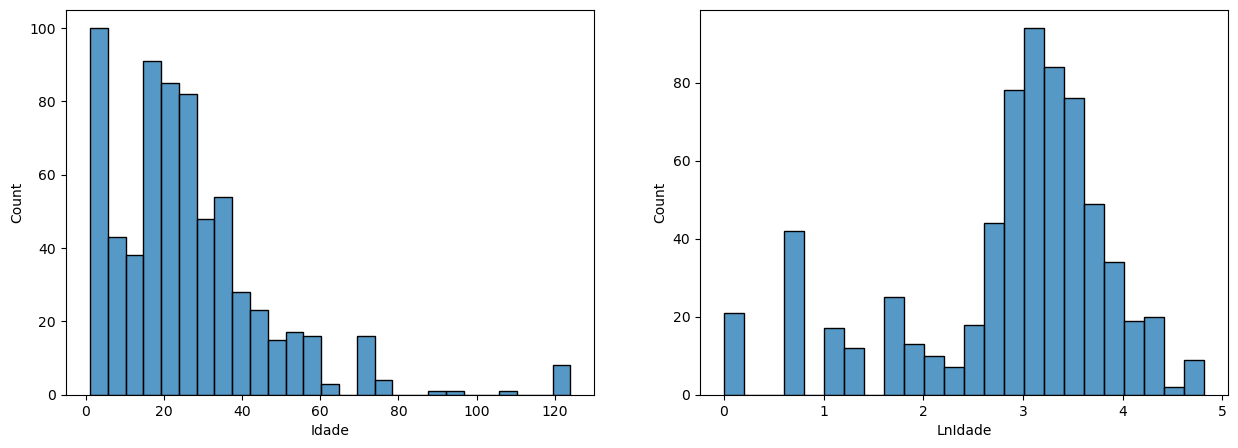

In [222]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="Idade", ax=ax[0])
sns.histplot(data=gdf_HousingMarket_AvrIlh, x="LnIdade", ax=ax[1])
fig.show()

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/2979971259.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


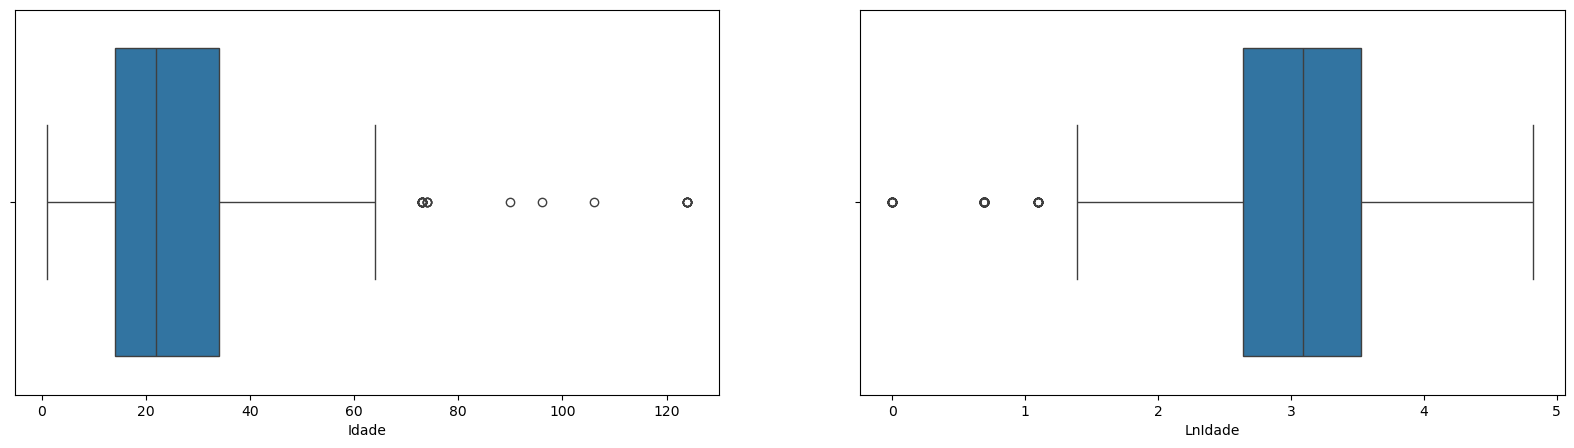

In [223]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.boxplot(x=gdf_HousingMarket_AvrIlh["Idade"], ax=ax[0])
sns.boxplot(x=gdf_HousingMarket_AvrIlh["LnIdade"], ax=ax[1])
fig.show()

#### Variáveis categóricas

##### Variável independente - preservação

In [239]:
gdf_HousingMarket_AvrIlh.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'A', 'Year', 'SOURCE_ID',
       'Construc_Year', 'geometry', 'DICOFRE18', 'FREG18_la', 'AREAFREG18',
       'MUNICOD', 'MUNI_Name', 'LnPrice', 'LnA', 'PriceM2', 'LnPriceM2',
       'LnTypology', 'Idade', 'LnIdade'],
      dtype='object')

In [240]:
status_cod = { 1 : "new", 2 : "used_10y", 3 : "used_1025y", 4 : "used_plus25y"}

In [241]:
gdf_HousingMarket_AvrIlh['Status'].unique()

array([4, 2, 3, 1])

In [242]:
gdf_HousingMarket_AvrIlh["Status_Desig"]=gdf_HousingMarket_AvrIlh['Status'].map(status_cod)

In [243]:
gdf_HousingMarket_AvrIlh.groupby('Status')['ID'].count()

Status
1     21
2    122
3    257
4    274
Name: ID, dtype: int64

In [244]:
gdf_HousingMarket_AvrIlh.groupby('Status_Desig')['Price'].mean()

Status_Desig
new             299423.809524
used_1025y      229676.945525
used_10y        288959.180328
used_plus25y    181121.062044
Name: Price, dtype: float64

In [245]:
gdf_HousingMarket_AvrIlh.groupby('Status_Desig')['Idade'].mean()

Status_Desig
new              1.000000
used_1025y      19.206226
used_10y         4.352459
used_plus25y    43.598540
Name: Idade, dtype: float64

In [246]:
gdf_HousingMarket_AvrIlh = pd.concat([gdf_HousingMarket_AvrIlh, pd.get_dummies(gdf_HousingMarket_AvrIlh['Status_Desig'], prefix = "D")], axis = 1 )

# Para evitar multicolinariedade eliminamos a variável D_new 
# NOTA: ao eliminar uma das variáveis dummies, estamos a assumir que a variável eliminada é a base da comparação
# ou seja, o coeficiente da variável eliminada é zero, e os coeficientes das restantes variáveis dummies são "variações" relativas à variável eliminada

gdf_HousingMarket_AvrIlh.drop(columns=['D_new'], inplace=True)

##### Variável Independente - natureza

In [250]:
gdf_HousingMarket_AvrIlh['Nature'].unique()

array([1, 2])

In [251]:
nature_cod = { 1 : "apartment", 2 : "house"}

In [252]:
gdf_HousingMarket_AvrIlh["Nature_Desig"]=gdf_HousingMarket_AvrIlh['Nature'].map(nature_cod)

In [253]:
gdf_HousingMarket_AvrIlh.groupby('Nature_Desig')['ID'].count()

Nature_Desig
apartment    398
house        276
Name: ID, dtype: int64

In [254]:
gdf_HousingMarket_AvrIlh.groupby('Nature_Desig')['Price'].mean()

Nature_Desig
apartment    191525.489950
house        267999.713768
Name: Price, dtype: float64

In [255]:
gdf_HousingMarket_AvrIlh = pd.concat([gdf_HousingMarket_AvrIlh, pd.get_dummies(gdf_HousingMarket_AvrIlh['Nature_Desig'], prefix = "D")], axis = 1 )

# Para evitar multicolinariedade eliminamos a variável D_house 
# NOTA: ao eliminar uma das variáveis dummies, estamos a assumir que a variável eliminada é a base da comparação
# ou seja, o coeficiente da variável eliminada é zero, e os coeficientes das restantes variáveis dummies são "variações" relativas à variável eliminada

gdf_HousingMarket_AvrIlh.drop(columns=['D_house'], inplace=True)

##### Variável independente - fonte de dados

In [275]:
gdf_HousingMarket_AvrIlh['SOURCE_ID'].unique()

array([2., 5., 4., 7.])

In [276]:
source_cod = { 1 : "PrimeYield", 2 : "Imovirtual", 3 : "Idealista", 4 : "Sapo", 5 : "C21", 6 : "Mister", 7 : "Casafari"}

In [277]:
gdf_HousingMarket_AvrIlh["Source_Desig"]=gdf_HousingMarket_AvrIlh['SOURCE_ID'].map(source_cod)

In [278]:
gdf_HousingMarket_AvrIlh.groupby('Source_Desig')['ID'].count()

Source_Desig
C21           244
Casafari       10
Imovirtual    137
Sapo          283
Name: ID, dtype: int64

In [279]:
gdf_HousingMarket_AvrIlh.groupby('Source_Desig')['Price'].mean()

Source_Desig
C21           194871.991803
Casafari      151750.000000
Imovirtual    183557.591241
Sapo          268485.547703
Name: Price, dtype: float64

In [280]:
gdf_HousingMarket_AvrIlh = pd.concat([gdf_HousingMarket_AvrIlh, pd.get_dummies(gdf_HousingMarket_AvrIlh['Source_Desig'], prefix = "D")], axis = 1 )


##### Variável independente - Variável temporal

In [281]:
gdf_HousingMarket_AvrIlh.groupby('Year')['ID'].count()

Year
2018    131
2019     33
2020    133
2021    210
2022    161
2023      6
Name: ID, dtype: int64

In [282]:
gdf_HousingMarket_AvrIlh.groupby('Year')['Price'].mean()

Year
2018    183884.351145
2019    253007.424242
2020    186144.097744
2021    227085.523810
2022    272452.459627
2023    241166.666667
Name: Price, dtype: float64

In [283]:
gdf_HousingMarket_AvrIlh.groupby('Year')['A'].mean()

Year
2018    143.359695
2019    189.781818
2020    148.042030
2021    153.620143
2022    145.912422
2023     90.333333
Name: A, dtype: float64

In [284]:
gdf_HousingMarket_AvrIlh = pd.concat([gdf_HousingMarket_AvrIlh, pd.get_dummies(gdf_HousingMarket_AvrIlh['Year'], prefix = "D")], axis = 1 )

# Para evitar multicolinariedade eliminamos a variável D_y2018 
# NOTA: ao eliminar uma das variáveis dummies, estamos a assumir que a variável eliminada é a base da comparação
# ou seja, o coeficiente da variável eliminada é zero, e os coeficientes das restantes variáveis dummies são "variações" relativas à variável eliminada

gdf_HousingMarket_AvrIlh.drop(columns=['D_2018'], inplace=True)

In [285]:
gdf_HousingMarket_AvrIlh.dtypes

ID                   int64
Nature               int64
Typology             int64
Status               int64
Price              float64
A                  float64
Year                 int64
SOURCE_ID          float64
Construc_Year        int64
geometry          geometry
DICOFRE18           object
FREG18_la           object
AREAFREG18         float64
MUNICOD             object
MUNI_Name           object
LnPrice            float64
LnA                float64
PriceM2            float64
LnPriceM2          float64
LnTypology         float64
Idade                int64
LnIdade            float64
Status_Desig        object
D_used_1025y          bool
D_used_10y            bool
D_used_plus25y        bool
Nature_Desig        object
D_apartment           bool
D_2019                bool
D_2020                bool
D_2021                bool
D_2022                bool
D_2023                bool
Source_Desig        object
D_C21                 bool
D_Casafari            bool
D_Imovirtual          bool
D

In [286]:
gdf_HousingMarket_AvrIlh.shape

(674, 43)

O mercado habitacional é um mercado que varia ao longo do tempo, pelo que importa considerar uma estratégia de modelação dos efeitos temporais de acordo com os objetivos da nossa análise e tendo em conta que os dados foram recolhidos ao longo de um período de tempo alargado. Neste caso, uma vez que estamos focados na modelação dos efeitos espaciais (dados em "secção" - "cross-section") podemos fixar os efeitos temporais de uma forma simples, considerando variáveis "dummy" para os períodos de tempo fornecidos (ano).

### Análise econométrica espacial

#### Preparação e Seleção dos dados

In [287]:
gdf_HousingMarket_AvrIlh.columns

Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'A', 'Year', 'SOURCE_ID',
       'Construc_Year', 'geometry', 'DICOFRE18', 'FREG18_la', 'AREAFREG18',
       'MUNICOD', 'MUNI_Name', 'LnPrice', 'LnA', 'PriceM2', 'LnPriceM2',
       'LnTypology', 'Idade', 'LnIdade', 'Status_Desig', 'D_used_1025y',
       'D_used_10y', 'D_used_plus25y', 'Nature_Desig', 'D_apartment', 'D_2019',
       'D_2020', 'D_2021', 'D_2022', 'D_2023', 'Source_Desig', 'D_C21',
       'D_Casafari', 'D_Imovirtual', 'D_Sapo', 'D_2019', 'D_2020', 'D_2021',
       'D_2022', 'D_2023'],
      dtype='object')

In [288]:
select_variables = ['ID', 
                    'LnPrice', 'LnPriceM2', 
                    'LnA',
                    'LnTypology', 'LnIdade', 
                    'D_used_1025y', 'D_used_10y', 'D_used_plus25y', 
                    'D_apartment',
                    'D_C21', 'D_Imovirtual', 'D_Sapo', 
                    'D_2019', 'D_2020', 'D_2021', 'D_2022', 'D_2023',
                    'geometry']

In [289]:
print(gdf_HousingMarket_AvrIlh.columns)


Index(['ID', 'Nature', 'Typology', 'Status', 'Price', 'A', 'Year', 'SOURCE_ID',
       'Construc_Year', 'geometry', 'DICOFRE18', 'FREG18_la', 'AREAFREG18',
       'MUNICOD', 'MUNI_Name', 'LnPrice', 'LnA', 'PriceM2', 'LnPriceM2',
       'LnTypology', 'Idade', 'LnIdade', 'Status_Desig', 'D_used_1025y',
       'D_used_10y', 'D_used_plus25y', 'Nature_Desig', 'D_apartment', 'D_2019',
       'D_2020', 'D_2021', 'D_2022', 'D_2023', 'Source_Desig', 'D_C21',
       'D_Casafari', 'D_Imovirtual', 'D_Sapo', 'D_2019', 'D_2020', 'D_2021',
       'D_2022', 'D_2023'],
      dtype='object')


In [290]:
gdf_HousingMarket_AvrIlh_modelling = gdf_HousingMarket_AvrIlh[select_variables]

In [291]:
gdf_HousingMarket_AvrIlh_modelling.shape

(674, 24)

#### Heterogeneidade espacial

<Axes: >

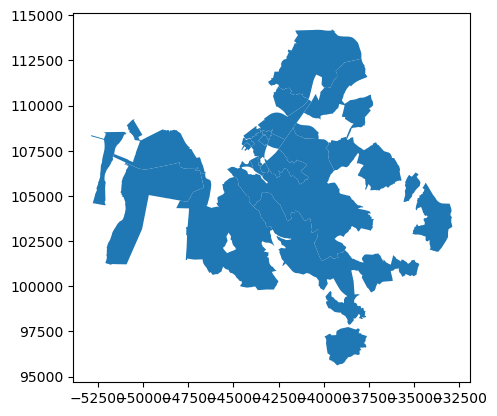

In [297]:
AE_AVRILH_MACRO_12UTs = gpd.read_file(r'geopackage_ETE2425.gpkg', layer='AE_AVRILH_MACRO_12UTs')
AE_AVRILH_MACRO_12UTs.plot()

In [298]:
print(gdf_HousingMarket_AvrIlh_modelling.shape)
gdf_HousingMarket_AvrIlh_modelling = gdf_HousingMarket_AvrIlh_modelling.overlay(AE_AVRILH_MACRO_12UTs, how='intersection')
gdf_HousingMarket_AvrIlh_modelling.drop(columns='spss_clust', inplace=True)
gdf_HousingMarket_AvrIlh_modelling.shape

(674, 24)


(674, 25)

In [299]:
gdf_HousingMarket_AvrIlh_modelling.columns

Index(['ID', 'LnPrice', 'LnPriceM2', 'LnA', 'LnTypology', 'LnIdade',
       'D_used_1025y', 'D_used_10y', 'D_used_plus25y', 'D_apartment', 'D_C21',
       'D_Imovirtual', 'D_Sapo', 'D_2019', 'D_2019', 'D_2020', 'D_2020',
       'D_2021', 'D_2021', 'D_2022', 'D_2022', 'D_2023', 'D_2023',
       'MACROZONAS12', 'geometry'],
      dtype='object')

In [300]:
gdf_HousingMarket_AvrIlh_modelling['MACROZONAS12'].unique()

array(['MixedF08', 'MixedF04', 'MixedF05', 'MixedF12', 'MixedF10',
       'MixedF06', 'MixedF07', 'MixedF09', 'MixedF03', 'MixedF11',
       'MixedF01', 'MixedF02'], dtype=object)

In [301]:
gdf_HousingMarket_AvrIlh_modelling.groupby('MACROZONAS12')['ID'].count()

MACROZONAS12
MixedF01     33
MixedF02     60
MixedF03     92
MixedF04    115
MixedF05     39
MixedF06     72
MixedF07     16
MixedF08     28
MixedF09     44
MixedF10     38
MixedF11     38
MixedF12     99
Name: ID, dtype: int64

In [306]:
gdf_HousingMarket_AvrIlh_modelling = pd.concat([gdf_HousingMarket_AvrIlh_modelling, pd.get_dummies(gdf_HousingMarket_AvrIlh_modelling['MACROZONAS12'], prefix = "D")], axis = 1 )

# Para evitar multicolinariedade eliminamos a variável D_MixedF08 
# NOTA: ao eliminar uma das variáveis dummies, estamos a assumir que a variável eliminada é a base da comparação
# ou seja, o coeficiente da variável eliminada é zero, e os coeficientes das restantes variáveis dummies são "variações" relativas à variável eliminada

gdf_HousingMarket_AvrIlh_modelling.drop(columns=['D_MixedF04'], inplace=True)

#### Matrizes de pesos / vizinhanças

In [328]:
from pysal.lib import weights

In [329]:
gdf_HousingMarket_AvrIlh_modelling.columns

Index(['ID', 'LnPrice', 'LnPriceM2', 'LnA', 'LnTypology', 'LnIdade',
       'D_used_1025y', 'D_used_10y', 'D_used_plus25y', 'D_apartment', 'D_C21',
       'D_Imovirtual', 'D_Sapo', 'D_2019', 'D_2019', 'D_2020', 'D_2020',
       'D_2021', 'D_2021', 'D_2022', 'D_2022', 'D_2023', 'D_2023',
       'MACROZONAS12', 'geometry', 'D_MixedF01', 'D_MixedF02', 'D_MixedF03',
       'D_MixedF05', 'D_MixedF06', 'D_MixedF07', 'D_MixedF08', 'D_MixedF09',
       'D_MixedF10', 'D_MixedF11', 'D_MixedF12', 'LnPrice_lag_wrook'],
      dtype='object')

Escolha de um caso para análise detalhada

#### K-Vizinhos mais próximos (KNN)

In [330]:
# combine x and y
vector_pnts = np.column_stack([gdf_HousingMarket_AvrIlh_modelling.geometry.x, gdf_HousingMarket_AvrIlh_modelling.geometry.y])

In [331]:
wk4 = libpysal.cg.brute_knn(vector_pnts, 4, mode='xyz', radius=60000)

NameError: name 'libpysal' is not defined

In [ ]:
wk4 = libpysal.weights.W(wk4)

In [ ]:
wk4.n

In [ ]:
wk4

In [ ]:
gdf_HousingMarket_AvrIlh_modelling.shape

In [ ]:
# Row standardization of W
wk4.transform = 'r'

In [ ]:
type(wk4)

In [ ]:
print("»» Número de casos: \n" , wk4.n)
print("»» Número de casos sem vizinhos: \n" ,wk4.islands)
print("»» Indicador de densidade da matriz: \n" , wk4.pct_nonzero)
print("»» Vizinhos (referência) da habitação [225]: \n" , wk4.neighbors[125])
print("»» Pesos atríbuidos aos Vizinhos da habitação [225]: \n", wk4[125])
print(pd.Series(wk4.cardinalities).plot.hist(color='k') )

###### Análise exploratória (KNN)

In [ ]:
# from pysal.explore import esda
from esda.moran import Moran
from esda.moran import Moran_Local

# https://splot.readthedocs.io/en/latest/api.html
# pysal.viz »» splot [splot.esda] (tem métodos para esda e outras componentes - ver api)
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_moran

In [ ]:
moran_LnPrice_wk4 = Moran(gdf_HousingMarket_AvrIlh_modelling['LnPrice'], wk4)
moran_LnPrice_wk4.I, moran_LnPrice_wk4.p_sim

In [ ]:
# Compute spatial lag of `LnPrice_lag`
gdf_HousingMarket_AvrIlh_modelling["LnPrice_lag_wk4"]  = weights.lag_spatial(wk4, gdf_HousingMarket_AvrIlh_modelling['LnPrice'])


In [ ]:
# Setup the figure and axis
figura, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x="LnPrice", y="LnPrice_lag_wk4", data=gdf_HousingMarket_AvrIlh_modelling)
# Display
plt.show()

In [ ]:
# calculate Moran_Local and plot
moranLocal_LnPrice_wk4 = Moran_Local(gdf_HousingMarket_AvrIlh_modelling['LnPrice'], wk4)

In [ ]:
figura, ax = moran_scatterplot(moranLocal_LnPrice_wk4, p=0.05)
ax.set_xlabel('Ln Preço (€)')
ax.set_ylabel('Spatial Lag do Ln Preço (€)')
plt.show()

In [ ]:
lisa_cluster(moranLocal_LnPrice_wk4, gdf_HousingMarket_AvrIlh_modelling, p=0.05, figsize = (9,9))
plt.show()

In [ ]:
figura, ax = plt.subplots(figsize = (10,10) )
ax.use_sticky_edges = False
#ax.margins(x=-0.45, y=-0.45)
#ax.set_aspect('equal')



lisa_cluster(moranLocal_LnPrice_wk4, gdf_HousingMarket_AvrIlh_modelling, p=0.05, ax=ax)

AE_AVRILH_MACRO_12UTs.plot(ax=ax, 
                           zorder=3, 
                           color='whitesmoke', 
                           edgecolor='black', 
                           linewidth=1, 
                           linestyle='--',
                           alpha = 0.4 )


ax.set_xbound(-45000, -38000 )
ax.set_ybound(111000, 104000)
ax.set_axis_off()
ax.set_title('Grafo geográfico da matriz de pesos espaciais - KNN (k=4)')

In [ ]:
from scipy import stats

gdf_HousingMarket_AvrIlh_modelling['LnPrice_zscore']  = stats.zscore(gdf_HousingMarket_AvrIlh_modelling['LnPrice'] )
gdf_HousingMarket_AvrIlh_modelling['LnPrice_lag_wk4_zscore']  = stats.zscore(gdf_HousingMarket_AvrIlh_modelling['LnPrice_lag_wk4'] )

In [ ]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='LnPrice_zscore', y='LnPrice_lag_wk4_zscore', 
                ci=None, data=gdf_HousingMarket_AvrIlh_modelling, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

#### Polígonos de Voronoi

IMPORTANTE: Neste caso, temos várias habitações (representadas por pontos) que têm exatamente a mesma coordenada geográfica (possível explicação? Habitações no mesmo edifício, como é o caso de um edifício de apartamentos!). Assim, para construir polígonos de voronoi, é necessário adotar uma estratégia indireta. Neste notebook, adota-se a estratégia de i) eliminar os pontos coincidentes ii) calculara os polígonos de voronoi para os pontos distintos iii) atribuir os polígonos de voronoi aos registos originais (ou seja, haverá registos com polígonos coincidentes!). Note-se que esta estratégia é uma simplificação e que poderá não ser a mais adequada para todos os casos. A determinação da matriz de pesos irá considerar os polígonos coincidentes como vizinhos uma vez que a operação decorre por comparação geométrica dos pontos coincidentes de fronteira dos polígonos.

In [311]:
from libpysal.cg import voronoi_frames

In [312]:
# combine x and y
vector_pnts_uniques = np.column_stack([gdf_HousingMarket_AvrIlh_modelling.geometry.x, gdf_HousingMarket_AvrIlh_modelling.geometry.y])

In [313]:
vector_pnts_uniques

array([[-44026.91216071, 108117.74600696],
       [-43807.99967213, 108010.09996583],
       [-34867.07651303, 105738.23397163],
       ...,
       [-50087.08827156, 106339.4911597 ],
       [-45782.50763405, 103977.1376461 ],
       [-46297.87960207, 100790.17970605]])

In [314]:
voronoi_polygons_gdf, voronoi_vertices_gdf = voronoi_frames(vector_pnts_uniques)

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/418560122.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi_polygons_gdf, voronoi_vertices_gdf = voronoi_frames(vector_pnts_uniques)
/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/418560122.py:1: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi_polygons_gdf, voronoi_vertices_gdf = voronoi_frames(vector_pnts_uniques)


Text(0.5, 1.0, 'Diagrama de Voronoi para os pontos de localização das habitações')

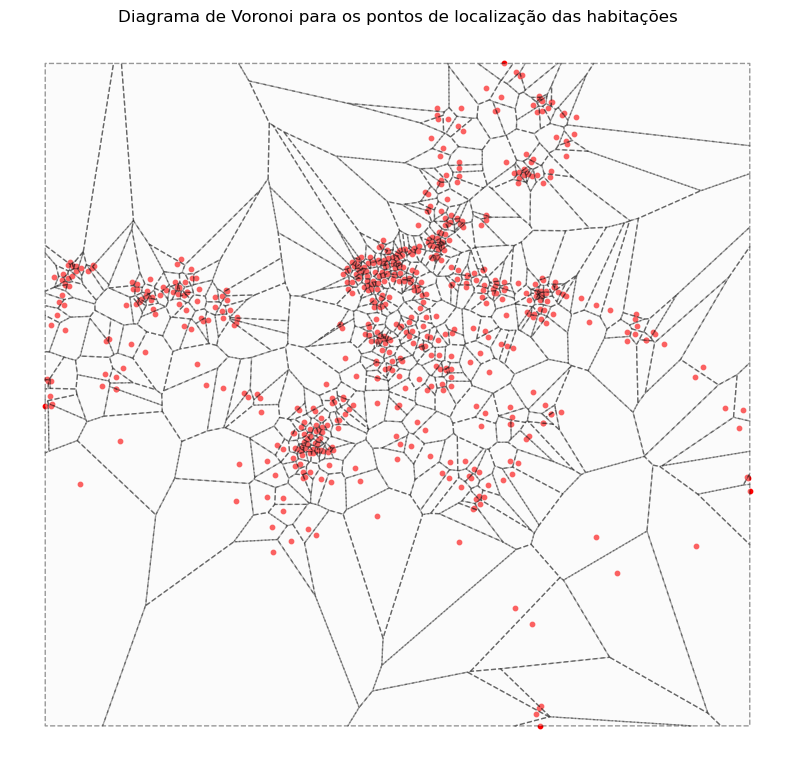

In [315]:
figura, ax = plt.subplots(figsize = (10,10) )
ax.use_sticky_edges = False
#ax.margins(x=-0.45, y=-0.45)
#ax.set_aspect('equal')

gdf_HousingMarket_AvrIlh_modelling.plot(ax=ax, zorder=2, color='red', markersize=10)

voronoi_polygons_gdf.plot(ax=ax, 
                           zorder=3, 
                           color='whitesmoke', 
                           edgecolor='black', 
                           linewidth=1, 
                           linestyle='--',
                           alpha = 0.4 )


# ax.set_xbound(-45000, -38000 )
# ax.set_ybound(111000, 104000)
ax.set_axis_off()
ax.set_title('Diagrama de Voronoi para os pontos de localização das habitações')

In [316]:
w_rook = weights.contiguity.Rook.from_dataframe(voronoi_polygons_gdf)

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_61790/1914507877.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook = weights.contiguity.Rook.from_dataframe(voronoi_polygons_gdf)


»» Número de casos: 
 674
»» Número de casos sem vizinhos: 
 []
»» Indicador de densidade da matriz: 
 0.8730375366517271
»» Vizinhos (referência) da habitação [225]: 
 [201, 457, 205, 94]
»» Pesos atríbuidos aos Vizinhos da habitação [225]: 
 {201: 1.0, 457: 1.0, 205: 1.0, 94: 1.0}
Axes(0.125,0.11;0.775x0.77)


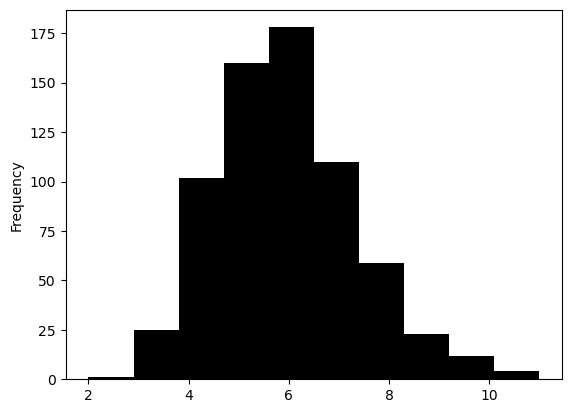

In [317]:
print("»» Número de casos: \n" , w_rook.n)
print("»» Número de casos sem vizinhos: \n" ,w_rook.islands)
print("»» Indicador de densidade da matriz: \n" , w_rook.pct_nonzero)
print("»» Vizinhos (referência) da habitação [225]: \n" , w_rook.neighbors[125])
print("»» Pesos atríbuidos aos Vizinhos da habitação [225]: \n", w_rook[125])
print(pd.Series(w_rook.cardinalities).plot.hist(color='k') )

In [318]:
w_rook.transform = 'r'

In [319]:
moran_LnPrice_wrook = Moran(gdf_HousingMarket_AvrIlh_modelling['LnPrice'], w_rook)
moran_LnPrice_wrook.I, moran_LnPrice_wrook.p_sim

(np.float64(0.178941619229264), np.float64(0.001))

In [320]:
# Compute spatial lag of `LnPrice_lag`
gdf_HousingMarket_AvrIlh_modelling["LnPrice_lag_wrook"]  = weights.lag_spatial(w_rook, gdf_HousingMarket_AvrIlh_modelling['LnPrice'])

In [321]:
# calculate Moran_Local and plot
moranLocal_LnPrice_wrook = Moran_Local(gdf_HousingMarket_AvrIlh_modelling['LnPrice'], w_rook)

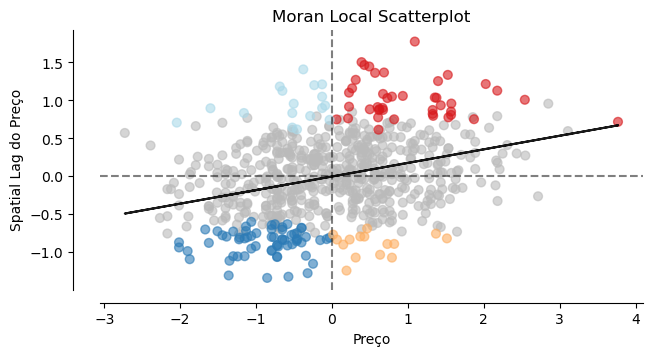

In [322]:
figura, ax = moran_scatterplot(moranLocal_LnPrice_wrook, p=0.05)
ax.set_xlabel('Preço')
ax.set_ylabel('Spatial Lag do Preço')
plt.show()

Text(0.5, 1.0, 'Grafo geográfico da matriz de pesos espaciais - WRook a partir de Poligonos de Voronoi')

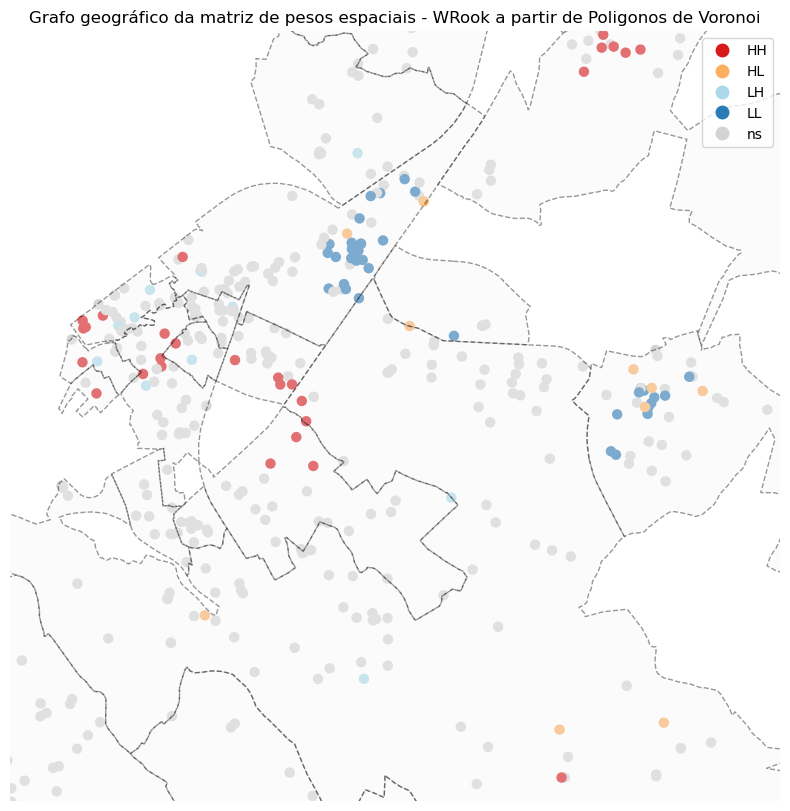

In [323]:
figura, ax = plt.subplots(figsize = (10,10) )
ax.use_sticky_edges = False
#ax.margins(x=-0.45, y=-0.45)
#ax.set_aspect('equal')



lisa_cluster(moranLocal_LnPrice_wrook, gdf_HousingMarket_AvrIlh_modelling, p=0.05, ax=ax)

AE_AVRILH_MACRO_12UTs.plot(ax=ax, 
                           zorder=3, 
                           color='whitesmoke', 
                           edgecolor='black', 
                           linewidth=1, 
                           linestyle='--',
                           alpha = 0.4 )


ax.set_xbound(-45000, -38000 )
ax.set_ybound(111000, 104000)
ax.set_axis_off()
ax.set_title('Grafo geográfico da matriz de pesos espaciais - WRook a partir de Poligonos de Voronoi')

### Modelos econométricos espaciais

Mas como **escolher a especificação / modelo** para incorporar relações de dependência espacial no nosso modelo? 
Os dois mecanismos principais são:
- Dependência **no valor da variável dependente** $\rightarrow$ modelo com lag espacial (SAR).
- Dependência **nos erros** $\rightarrow$ modelo com erro espacial (SEM).

Para nos ajudar no processo de decisão, além da teoria, podemos socorrer-nos de dois testes estatísticos fundamentais:
- **Testes de Multiplicadores de Lagrange (LM)**.
- **Testes de Razão de Verosimilhanças (LR)**.

---

**O Desafio da Especificação de Modelos em Econometria Espacial**

Ao escolher um modelo econométrico espacial, é importante determinar se existe dependência espacial nos dados. Modelos incorretamente especificados resultam em estimadores ineficientes, viesados ou inconsistentes.

Exemplos:
1. **Modelo com Lag Espacial na variável Y**:

$$
y = \rho W y + X\beta + \varepsilon
$$

2. **Modelo de erro (SEM)**:

$$
y = X\beta + u, \quad u = \lambda W u + \varepsilon
$$

---

**Testes de Multiplicadores de Lagrange (LM)**

Os **testes LM** servem como diagnóstico inicial para indicar se há dependência espacial. Baseiam-se no **gradiente** da função de log-verosimilhança sob a hipótese nula.

**Ideia Geral:**
- Estima-se o modelo **OLS clássico**, sem efeitos espaciais.
- Com base nos resíduos $e$, calcula-se o LM.

**LM para Lag Espacial (SAR/SLM)**

- **Hipótese Nula**: $H_0: \rho = 0$
- **Hipótese Alternativa**: $H_1: \rho \neq 0$

**Estatística LM Lag**:

$$
LM_{\text{lag}} = \frac{ \left( e' W y / \sigma^2 \right)^2 }{ tr(W'W + W W') }
$$

- $e = y - X\hat{\beta}$: resíduos do OLS.
- $\sigma^2 = \dfrac{e'e}{n}$: variância dos resíduos.

**LM para Erro Espacial (SEM)**

- **Hipótese Nula**: $H_0: \lambda = 0$
- **Hipótese Alternativa**: $H_1: \lambda \neq 0$

**Estatística LM Error**:

$$
LM_{\text{error}} = \frac{ \left( e' W e / \sigma^2 \right)^2 }{ tr(W'W + W W') }
$$

Ambos os testes seguem uma distribuição qui-quadrado com 1 grau de liberdade:

$$
LM \sim \chi^2(1)
$$

**Testes LM Robustos**
Se ambos os LM clássicos forem significativos, utiliza-se as versões robustas para distinguir entre SAR e SEM.

- **Robusto LM Lag**:

$$
RLM_{\text{lag}} = \frac{LM_{\text{lag}}}{1 - \dfrac{tr(W W + W' W)}{n}}
$$

- **Robusto LM Error**:

$$
RLM_{\text{error}} = \frac{LM_{\text{error}}}{1 - \dfrac{tr(W W + W' W)}{n}}
$$

---

**Testes de Razão de Verosimilhanças (LR)**

Os **testes de razão de verosimilhanças (LR)** comparam modelos **aninhados** através das suas **log-verosimilhanças**.

Ideia Geral:
- Estima-se o **modelo restrito** (por exemplo, OLS).
- Estima-se o **modelo irrestrito** (por exemplo, SAR ou SEM).
- Compara-se as **log-verosimilhanças**.

**Estatística LR**:

$$
LR = 2 \left( \ln L_{irrestrito} - \ln L_{restrito} \right)
$$

Segue uma distribuição qui-quadrado com $k$ graus de liberdade, onde $k$ é a diferença no número de parâmetros estimados entre os modelos.

**Exemplo:**
- Comparar OLS (restrito) e SAR (irrestrito):
  - $k = 1$ (parâmetro $\rho$).

---

**Procedimento Formal de Testes de Hipóteses**

| **Passo**              | **Descrição**                                         |
|------------------------|-------------------------------------------------------|
| **1. Hipóteses**       | $H_0$: sem dependência espacial; $H_1$: com efeito espacial |
| **2. Estatística**     | LM ou LR                                              |
| **3. Distribuição**    | $\chi^2(1)$ (ou $\chi^2(k)$)                         |
| **4. Regra de Decisão**| Rejeitar $H_0$ se estatística $>$ $\chi^2_{\alpha, 1}$ |
| **5. Conclusão**       | Rejeitar $H_0$: incluir efeitos espaciais            |

---

**4. Exemplo de Aplicação (Passo-a-Passo)**

**Objetivo: Escolher entre SAR e SEM**
1. Estimar **OLS**:

$$
y = X\hat{\beta}_{OLS} + e
$$

2. Calcular os **LM tests**:
   - $LM_{\text{lag}}$ e $LM_{\text{error}}$.
3. Se ambos forem significativos:
   - Calcular **Robustos LM**:
     - Se apenas o robusto **lag** for significativo $\rightarrow$ SAR.
     - Se apenas o robusto **error** for significativo $\rightarrow$ SEM.
4. Estimar o modelo escolhido (SAR ou SEM).
5. Comparar modelos mais complexos com **LR tests** (ex: SDM).

---

**Fundamento Matemático**

| **Testes LM** | Baseados nas **derivadas primeiras** (gradientes) da log-verosimilhança sob $H_0$. Rápidos, não exigem re-estimar modelos. |
|---------------|-----------------------------------------------------------------------------------------------------------------------------|
| **Testes LR** | Baseados nas **log-verosimilhanças** de modelos aninhados. Exigem estimativas completas dos modelos.                        |

---

**Quando Usar Cada Teste?**

| **Teste**           | **Objetivo**                            | **Melhor Uso**                      |
|---------------------|----------------------------------------|------------------------------------|
| **LM**              | Detecção inicial de autocorrelação     | Diagnóstico a partir de OLS        |
| **LM Robusto**      | Diferenciar dependência lag vs. erro   | Quando ambos LM forem significativos |
| **LR**              | Comparação formal entre modelos        | Após estimação dos modelos espaciais |

---

#### Modelo SLX

A nossa árvore de decisão, embora seja fundamentalmente guiada por um critério estatístico, leva-nos a uma primeira especificação que tem uma interpretação concreta no caso de estudo que estamos a trabalhar.

Com efeito o modelo SLX pode ser interpretado como uma especificação adequada para modelar um mercado habitacional onde prevalecem critérios de procura de casa que tendem a priviligiar a escolha de habitações que se encontram rodeadas (em termos espaciais) de habitações com caracaterísticas (físicas) semelhantes; por exemplo habitações com área maior ao redor da habitação preferida; ou seja, para duas habitações iguais, seria possível identificar que vários intervenientes no mercado que procuram habitação estariam dispostos a pagar mais por uma casa cercada por certos tipos de casas, e menos se fosse localizada no meio de outros tipos de habitação.

A forma como este fenómeno de dependência espacial pode ser introduzido num modelo explicativo dos preços da habitação passa por não só considerar os atributos da habitação em si mas também um seu "desfasamento espacial" (**spatial lag**). Formalmente, tal pode ser expresso como:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

onde $\sum_{j=1}^N w_{ij}x_{jk}$ representa um desfasamento espacial da $k$th variável independente (explicativa).

Na forma *matricial*, por forma a incluir explicitamente $\mathbf{W}$ temos:
$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

Esta especificação incorpora assim no  modelo dois tipos de efeitos: $\beta$ and $\gamma$. 
O efeito capturado em $\beta$ descrebe as mudanças induzidas em $y_i$ quando $X_{ik}$ sofre um efeito de uma unidade. [No caso concreto do exemplo em analise, uma vez que transformamos a nossa variável dependente  $y$ com a função logaritmo, os coeficientes $\beta$ podem ser interpretados com base no conceito de *elasticidade*, significando assim que uma mudança de uma unidade na variável  $x_i$ resultará numa $\beta$ mudança percentual no preço *y_i*]. 

O índice para a localização espacial, $i$ , é importante: estabelece exatamente onde (localização) é que o efeito de dependência espacial (definido pela matriz $\mathbf{W}$ ) ocorre. 
O mesmo ocorre para o efeito capturado (a estimar) pelo parâmetro $\gamma$ , que é interpretado como um efeito *indireto* de uma mudança em $X_i$. 

Estes efeitos podem ser conceptualizados de duas maneiras. Em primeiro lugar, podemos pensar em $\gamma$ simplesmente como *o efeito que uma mudança de unidade na variável $X_i$ estabelece na valorização de um ambiente de vizinhança "médio"* . No entanto, esta interpretação ignora o local efetivo onde esta mudança pode ocorrer. Na verdade, uma mudança em uma variável na localização $i$ resultará num contágio para a sua vizinhança em concreto. Ou seja, quando $x_i$ muda, também muda o *desfasamento espacial* de qualquer observação considerada espacialmente vizinha de $i$. O alcance (espacial) dessa mudança é guiado pelo definido na estrutura $\mathbf{W}$. Por exemplo, se pensarmos num local onde as habitações estão altamente conectadas (por exemplo um local de ocupação densa, como o centro?), uma alteração numa dada observação / localização terá um efeito (médio) menos relevante. Numa observação / localização com apenas um vizinho o efeito será  *exatamente* proporcional à quantidade de mudanças no único vizinho. Para descobrir o efeito indireto exato de uma mudança em $y$ causada pela mudança de $x_i$ numa observação / localização em particular temos de incluir então o desfasamento espacial associado à mudança em $X$. 


In [324]:
gdf_HousingMarket_AvrIlh_modelling.columns

Index(['ID', 'LnPrice', 'LnPriceM2', 'LnA', 'LnTypology', 'LnIdade',
       'D_used_1025y', 'D_used_10y', 'D_used_plus25y', 'D_apartment', 'D_C21',
       'D_Imovirtual', 'D_Sapo', 'D_2019', 'D_2019', 'D_2020', 'D_2020',
       'D_2021', 'D_2021', 'D_2022', 'D_2022', 'D_2023', 'D_2023',
       'MACROZONAS12', 'geometry', 'D_MixedF01', 'D_MixedF02', 'D_MixedF03',
       'D_MixedF05', 'D_MixedF06', 'D_MixedF07', 'D_MixedF08', 'D_MixedF09',
       'D_MixedF10', 'D_MixedF11', 'D_MixedF12', 'LnPrice_lag_wrook'],
      dtype='object')

In [325]:
select_variables_forLagX = ['LnA', 'LnTypology', 'LnIdade']

wX_wk4 = gdf_HousingMarket_AvrIlh_modelling.filter(items=select_variables_forLagX).apply(lambda x: weights.spatial_lag.lag_spatial(wk4, x) ).rename(columns=lambda c: 'w_'+c)
wX_wk4[:3]

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
gdf_HousingMarket_AvrIlh_modelling = pd.concat([gdf_HousingMarket_AvrIlh_modelling, wX_wk4], axis=1, join="inner")
gdf_HousingMarket_AvrIlh_modelling[:3]

In [ ]:
explanation_variables_M1 = select_base_Xvariables + wX_wk4.columns.tolist()
explanation_variables_M1

In [ ]:
M1 = OLS(
    gdf_HousingMarket_AvrIlh_modelling[['LnPrice']].astype(float).values, 
    gdf_HousingMarket_AvrIlh_modelling[explanation_variables_M1].astype(float).values,
    name_y='LnPrice', 
    name_x=explanation_variables_M1 )
    # w=wk4, 
    #spat_diag=True)

In [ ]:
print(M1.summary)

#### Modelo SDM

In [ ]:
M2 = ML_Lag(
    gdf_HousingMarket_AvrIlh_modelling[['LnPrice']].astype(float).values, 
    gdf_HousingMarket_AvrIlh_modelling[explanation_variables_M1].astype(float).values,
    name_y='LnPrice', 
    name_x=explanation_variables_M1,
    w=wk4)

In [ ]:
print(M2.summary)

In [ ]:
likratiotest(M2,M1)

#### Modelo SAR

In [ ]:
M3 = ML_Lag(
            gdf_HousingMarket_AvrIlh_modelling[['LnPrice']].astype(float).values, 
            gdf_HousingMarket_AvrIlh_modelling[explanation_variables_M1].astype(float).values,
            name_y='LnPrice', 
            name_x=explanation_variables_M1,
            w=wk4)

In [ ]:
print(M3.summary)

In [ ]:
likratiotest(M3,M2)

## Conclusão

A análise econométrica espacial das rendas habitacionais na região de Aveiro revela padrões de desigualdade espacial que têm implicações significativas no contexto económico e imobiliário. As áreas centrais, com rendas mais elevadas, estão fortemente associadas a uma melhor qualidade das infraestruturas, impulsionada pela procura e pelo dinamismo económico dessas zonas. Esse padrão evidencia uma concentração de recursos e oportunidades, que favorece as regiões mais próximas dos centros urbanos.

Por outro lado, as áreas mais periféricas, com rendas mais baixas, têm menor procura imobiliária e refletem um mercado mais estagnado, associado a uma menor atratividade para investimentos e desenvolvimento económico.

As zonas industriais, identificadas na categoria AB, acabam por ser uma exceção à regra e ilustram como o desenvolvimento económico local pode impactar os valores das rendas, criando áreas de transição onde a valorização imobiliária é mais lenta, mas com potencial de crescimento futuro. Isso pode ter implicações sociais, pois pode gerar uma mudança na dinâmica das populações, com a entrada de novos residentes e empresas.

Esses resultados destacam a necessidade de políticas públicas que promovem um desenvolvimento mais equilibrado de forma a minimizar as desigualdades no mercado imobiliário e favoreça a inclusão social e económica.

 O trabalho aqui apresentado foi realizado por:
- Ana Maria Rosca (108820);
- Filipa Santos (77632);
- Willian Pegorin (122970).

In [137]:
import geopandas as gpd

# Caminho do arquivo .gpkg
gpkg_path = r'BGRI21_16D.gpkg'

# Listar as layers
layers = gpd.io.file.fiona.listlayers(gpkg_path)

# Exibir as layers
print("Layers no GeoPackage:")
for layer in layers:
    print(layer)


AttributeError: 'NoneType' object has no attribute 'listlayers'